In [1]:
# file names with data
ifile = "Electron_gun_generic_full.root" #fixed electron gun @520 cm

In [2]:
import ROOT

Welcome to JupyROOT 6.24/00


In [3]:
# import libraries
import uproot3 as uproot
import uproot as uproot4
import numpy as np
#import numba
import awkward as ak

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)
import os,sys
import pandas as pd
from scipy.stats import halfnorm

In [5]:
from sklearn.cluster import KMeans
import random
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.stats import crystalball
from lmfit import Model
import copy
#from coffea import hist

In [6]:
# Process Data
def getData(fname="", procName="Events"):
    kn_dict = uproot.open(fname)["Events"].arrays()
    kn_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in kn_dict.items()}
    kn_events = ak.zip({"Hits":ak.zip({
                                      "detID":   kn_dict_ak1["hit_detID"],
                                      "edep":    kn_dict_ak1["hit_edep"],
                                      "elmID":   kn_dict_ak1["hit_elmID"],
                                      "truthx":  kn_dict_ak1["hit_truthx"],
                                      "truthy":  kn_dict_ak1["hit_truthy"],
                                      "truthz":  kn_dict_ak1["hit_truthz"],
                                      }),
                        "Electrons":ak.zip({
                                            "ge":      kn_dict_ak1["ge"],
                                        }),
                       }, depth_limit=1)
    return kn_events

In [7]:
# Create selections/masks
def emcal_selection(arr):
    mask = (arr.detID == 100)
    return mask

def h2_selection(arr):
    mask = (arr.detID >= 35) & (arr.detID <= 38)
    return mask

def st2_selection(arr):
    mask = (arr.detID >= 13) & (arr.detID <= 18)
    return mask

def st3_selection(arr):
    mask = (arr.detID >= 19) & (arr.detID <= 30)
    return mask

def h4_selection(arr):
    mask = (arr.detID >= 41) & (arr.detID <= 46)
    return mask

In [8]:
def printemcalhits_byevent(ifile):
    kn_events = getData(ifile,"Events")
    kn_hits = kn_events["Hits"]
    ecal_mask = ak.any(kn_hits.detID == 100, axis=1)
    ecal_index = np.where(ecal_mask)
    print('Fraction of events with hits reaching EMCAL: ',len(ecal_index[0])/len(kn_events))
    print("Let's print the evt numbers we can use to plot EMCAL clusters")
    print('Indices of evts w. EMCAL hits:',ecal_index)

In [9]:
# load data
kn_events = getData(ifile,"Events")

In [31]:
def emcal_byevent(ifile,evtNum):
    # set up EMCAL
    ntowersx=72
    ntowersy=36
    sizex=5.53 # in cm
    sizey=5.53 # in cm

    ecalx=[-200,200] #size in cm
    ecaly=[-100,100]
    binsx=ecalx[1]-ecalx[0]
    binsy=ecaly[1]-ecaly[0]
    
    kn_hits = kn_events[evtNum]["Hits"]
    kn_electrons = kn_events[evtNum]["Electrons"]
    
    ge = kn_electrons.ge # truth energy
    
    emcal_mask = emcal_selection(kn_hits)
    emcal_hits = kn_hits[emcal_mask]
    emcal_towerx = emcal_hits.elmID//ntowersy
    emcal_towery = emcal_hits.elmID%ntowersy
    emcal_truthx = emcal_hits.truthx
    emcal_truthy = emcal_hits.truthy
    emcal_x = ecalx[0]+emcal_towerx*sizex
    emcal_y = ecaly[0]+emcal_towery*sizey
    emcal_edep = emcal_hits.edep
    
    st3_mask = st3_selection(kn_hits)
    st3_hits = kn_hits[st3_mask]

    st2_mask = st2_selection(kn_hits)
    st2_hits = kn_hits[st2_mask]
    st2_truthx = st2_hits.truthx
    st2_truthy = st2_hits.truthy
    
    h2_mask = h2_selection(kn_hits)
    h2_hits = kn_hits[h2_mask]
    
    print("St3 hits %i, St2 hits %i, H2 hits %i"%(len(st3_hits),len(st2_hits),len(h2_hits)))
    print("Event "+str(evtNum)+": "+str(len(emcal_hits))+" hits")
    
    energy_weights = np.divide(np.array(emcal_edep),np.max(emcal_edep))
    
    # kmeans clustering
    
    # find best number of clusters
    wcss = 0
    wcss_list = []
    for k in range(1,11): # preform kmeans on 1-10 clusters to determine best number
        if k <= len(emcal_hits):
            kmeans = KMeans(n_clusters=k,random_state=0,max_iter=1000)
            X = np.vstack((np.array(emcal_x), np.array(emcal_y))).T
            Y = energy_weights
            wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
            predicted_kmeans = kmeans.predict(X, sample_weight = Y)
            centers = wt_kmeansclus.cluster_centers_
            wcss_test = wt_kmeansclus.inertia_
            wcss_list.append(wcss_test)
        if abs(wcss_test-wcss) > 500 or wcss == 0: # if the next number of clusters improved significantly from before
            wcss = wcss_test
            optimal_num_clusters = k
            
    if len(emcal_hits) >= optimal_num_clusters: # if more hits than optimal # clusters proceed normally
        kmeans = KMeans(n_clusters=optimal_num_clusters, random_state=0, max_iter=1000)
    else: # if less hits that optimal # clusters make optimal # clusters = # hits
        print("Defaulting to 'emcal_hits' # of clusters")
        optimal_num_clusters = len(emcal_hits)
        kmeans = KMeans(n_clusters= optimal_num_clusters, random_state=0, max_iter=1000)
        
    X = np.vstack((np.array(emcal_x), np.array(emcal_y))).T
    Y = energy_weights
    wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
    predicted_kmeans = kmeans.predict(X, sample_weight = Y)
    
    # energy weighted mean position
    sfc = .1135
    energy_weighted_mean_pos = []
    e_tot_cluster = []
    cells = []
    for i in range(optimal_num_clusters): # for each cluster
        e_weight_x = 0
        e_weight_y = 0
        e_tot = 0
        num_cells = 0
        for j in range(len(predicted_kmeans)): # for each hit
            if predicted_kmeans[j] == i: # check if hit belongs to cluster
                num_cells += 1 # update info
                e_tot += emcal_edep[j]
                e_weight_x += (emcal_edep[j])*X[:,0][j]
                e_weight_y += (emcal_edep[j])*X[:,1][j]
        
        energy_weighted_mean_pos.append([e_weight_x/e_tot,e_weight_y/e_tot])
        e_tot_cluster.append(e_tot)
        cells.append(num_cells)
    
    # energy weighted width calculation
    e_weight_width = []
    e_weight_width_r = []
    for i in range(optimal_num_clusters): # for each cluster
        x_mean = energy_weighted_mean_pos[i][0]
        y_mean = energy_weighted_mean_pos[i][1]
        e_width_x = 0
        e_width_y = 0
        e_width_r = 0
        for j in range(len(predicted_kmeans)): # for each hit
            if predicted_kmeans[j] == i: # if hit corresponds to cluster then update info
                e_width_x += (emcal_edep[j])*(X[:,0][j]-x_mean)**2
                e_width_y += (emcal_edep[j])*(X[:,1][j]-y_mean)**2
                vec_magnitude = ((X[:,0][j]-x_mean)**2 + (X[:,1][j]-y_mean)**2)**(1/2)
                e_width_r += (emcal_edep[j])*((vec_magnitude)**2)

        e_weight_width.append([(e_width_x/e_tot_cluster[i])**(1/2),(e_width_y/e_tot_cluster[i])**(1/2)])
        e_weight_width_r.append((e_width_r/e_tot_cluster[i])**(1/2))
    
    # truth energy
    particle_energy = ge[0]
    
    return (optimal_num_clusters,e_weight_width,e_weight_width_r,e_tot_cluster,particle_energy,energy_weighted_mean_pos,cells)

In [14]:
kn_hits = kn_events["Hits"]
ecal_mask = ak.any(kn_hits.detID == 100, axis=1)
ecal_index = np.where(ecal_mask)
print(ecal_index[0][:100])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, ... 97, 98, 99, 100, 101, 102, 103, 104, 105, 106]


In [39]:
# run analysis
kn_hits = kn_events["Hits"]
ecal_mask = ak.any(kn_hits.detID == 100, axis=1)
ecal_index = np.where(ecal_mask)
events = ecal_index[0]
#events = ecal_index[0][:1000]

cluster_energies = []
cluster_pos = []
particle_energy = []
event_energy = []
energy_residual = []
energy_resolution = []

for i in events:
    clus_en = []
    clus_pos = []
    print('Event #'+str(i))
    event_data = emcal_byevent(ifile,i)
    num_clusters = event_data[0]
    truth_energy = event_data[4]
    particle_energy.append(truth_energy)
    
    reco_hits_energy = 0
    for j in range(num_clusters):
        cluster_energy = event_data[3][j]
        clusterP = event_data[5][j]
        #cluster_energies.append(cluster_energy)
        clus_en.append(cluster_energy)
        clus_pos.append(clusterP)
        reco_hits_energy += cluster_energy
    cluster_energies.append(clus_en)
    cluster_pos.append(clus_pos)
    event_energy.append(reco_hits_energy)
    energy_residual.append(reco_hits_energy - truth_energy)
    energy_resolution.append((reco_hits_energy - truth_energy)/(truth_energy))

Event #0
St3 hits 6, St2 hits 6, H2 hits 2
Event 0: 52 hits
Event #1
St3 hits 6, St2 hits 6, H2 hits 2
Event 1: 42 hits
Event #2
St3 hits 6, St2 hits 6, H2 hits 2
Event 2: 41 hits
Event #3
St3 hits 6, St2 hits 6, H2 hits 2
Event 3: 51 hits
Event #4
St3 hits 12, St2 hits 6, H2 hits 2
Event 4: 36 hits
Event #5
St3 hits 6, St2 hits 6, H2 hits 2
Event 5: 45 hits
Event #6
St3 hits 12, St2 hits 6, H2 hits 2
Event 6: 45 hits
Event #7
St3 hits 6, St2 hits 6, H2 hits 3
Event 7: 46 hits
Event #8
St3 hits 6, St2 hits 6, H2 hits 2
Event 8: 32 hits
Event #9
St3 hits 0, St2 hits 4, H2 hits 0
Event 9: 2 hits
Event #10
St3 hits 6, St2 hits 6, H2 hits 2
Event 10: 50 hits
Event #11
St3 hits 6, St2 hits 6, H2 hits 2
Event 11: 44 hits
Event #12
St3 hits 6, St2 hits 6, H2 hits 2
Event 12: 44 hits
Event #13
St3 hits 6, St2 hits 6, H2 hits 2
Event 13: 58 hits
Event #14
St3 hits 12, St2 hits 6, H2 hits 2
Event 14: 46 hits
Event #15
St3 hits 6, St2 hits 6, H2 hits 2
Event 15: 49 hits
Event #16
St3 hits 12, St2

Event #140
St3 hits 12, St2 hits 6, H2 hits 2
Event 140: 54 hits
Event #142
St3 hits 6, St2 hits 6, H2 hits 2
Event 142: 27 hits
Event #143
St3 hits 6, St2 hits 6, H2 hits 2
Event 143: 37 hits
Event #144
St3 hits 6, St2 hits 6, H2 hits 2
Event 144: 46 hits
Event #145
St3 hits 6, St2 hits 6, H2 hits 2
Event 145: 46 hits
Event #146
St3 hits 6, St2 hits 6, H2 hits 2
Event 146: 51 hits
Event #147
St3 hits 12, St2 hits 6, H2 hits 2
Event 147: 43 hits
Event #148
St3 hits 6, St2 hits 6, H2 hits 2
Event 148: 27 hits
Event #149
St3 hits 12, St2 hits 6, H2 hits 2
Event 149: 43 hits
Event #151
St3 hits 12, St2 hits 6, H2 hits 2
Event 151: 47 hits
Event #152
St3 hits 6, St2 hits 6, H2 hits 2
Event 152: 48 hits
Event #153
St3 hits 6, St2 hits 6, H2 hits 2
Event 153: 43 hits
Event #154
St3 hits 6, St2 hits 6, H2 hits 2
Event 154: 24 hits
Event #155
St3 hits 12, St2 hits 6, H2 hits 2
Event 155: 71 hits
Event #156
St3 hits 6, St2 hits 6, H2 hits 2
Event 156: 41 hits
Event #157
St3 hits 6, St2 hits 6, 

Event #275
St3 hits 6, St2 hits 6, H2 hits 2
Event 275: 52 hits
Event #277
St3 hits 6, St2 hits 6, H2 hits 2
Event 277: 32 hits
Event #280
St3 hits 12, St2 hits 6, H2 hits 2
Event 280: 54 hits
Event #281
St3 hits 6, St2 hits 6, H2 hits 2
Event 281: 45 hits
Event #282
St3 hits 12, St2 hits 6, H2 hits 2
Event 282: 48 hits
Event #283
St3 hits 6, St2 hits 6, H2 hits 2
Event 283: 58 hits
Event #284
St3 hits 12, St2 hits 6, H2 hits 2
Event 284: 57 hits
Event #285
St3 hits 6, St2 hits 6, H2 hits 2
Event 285: 46 hits
Event #286
St3 hits 12, St2 hits 6, H2 hits 2
Event 286: 55 hits
Event #287
St3 hits 6, St2 hits 6, H2 hits 2
Event 287: 55 hits
Event #288
St3 hits 6, St2 hits 6, H2 hits 2
Event 288: 47 hits
Event #289
St3 hits 12, St2 hits 6, H2 hits 2
Event 289: 43 hits
Event #290
St3 hits 6, St2 hits 6, H2 hits 2
Event 290: 51 hits
Event #291
St3 hits 6, St2 hits 6, H2 hits 2
Event 291: 47 hits
Event #292
St3 hits 6, St2 hits 6, H2 hits 2
Event 292: 35 hits
Event #293
St3 hits 6, St2 hits 6, 

Event #416
St3 hits 6, St2 hits 6, H2 hits 2
Event 416: 51 hits
Event #417
St3 hits 6, St2 hits 6, H2 hits 2
Event 417: 43 hits
Event #418
St3 hits 0, St2 hits 6, H2 hits 1
Event 418: 23 hits
Event #419
St3 hits 12, St2 hits 6, H2 hits 2
Event 419: 49 hits
Event #420
St3 hits 6, St2 hits 6, H2 hits 2
Event 420: 72 hits
Event #421
St3 hits 6, St2 hits 6, H2 hits 2
Event 421: 44 hits
Event #422
St3 hits 12, St2 hits 6, H2 hits 2
Event 422: 52 hits
Event #424
St3 hits 6, St2 hits 6, H2 hits 2
Event 424: 38 hits
Event #425
St3 hits 12, St2 hits 6, H2 hits 2
Event 425: 39 hits
Event #426
St3 hits 6, St2 hits 6, H2 hits 2
Event 426: 47 hits
Event #427
St3 hits 6, St2 hits 6, H2 hits 2
Event 427: 47 hits
Event #428
St3 hits 6, St2 hits 6, H2 hits 2
Event 428: 41 hits
Event #429
St3 hits 6, St2 hits 6, H2 hits 2
Event 429: 37 hits
Event #431
St3 hits 6, St2 hits 6, H2 hits 2
Event 431: 47 hits
Event #432
St3 hits 6, St2 hits 6, H2 hits 2
Event 432: 32 hits
Event #433
St3 hits 6, St2 hits 6, H2

Event #557
St3 hits 6, St2 hits 6, H2 hits 2
Event 557: 32 hits
Event #558
St3 hits 6, St2 hits 6, H2 hits 2
Event 558: 40 hits
Event #559
St3 hits 6, St2 hits 6, H2 hits 2
Event 559: 25 hits
Event #560
St3 hits 6, St2 hits 6, H2 hits 2
Event 560: 24 hits
Event #561
St3 hits 0, St2 hits 0, H2 hits 0
Event 561: 1 hits
Defaulting to 'emcal_hits' # of clusters
Event #562
St3 hits 6, St2 hits 6, H2 hits 2
Event 562: 45 hits
Event #563
St3 hits 6, St2 hits 6, H2 hits 3
Event 563: 50 hits
Event #564
St3 hits 6, St2 hits 6, H2 hits 2
Event 564: 49 hits
Event #565
St3 hits 6, St2 hits 6, H2 hits 2
Event 565: 42 hits
Event #566
St3 hits 6, St2 hits 6, H2 hits 2
Event 566: 38 hits
Event #567
St3 hits 6, St2 hits 6, H2 hits 2
Event 567: 43 hits
Event #568
St3 hits 6, St2 hits 6, H2 hits 2
Event 568: 28 hits
Event #569
St3 hits 6, St2 hits 6, H2 hits 2
Event 569: 38 hits
Event #570
St3 hits 6, St2 hits 6, H2 hits 2
Event 570: 55 hits
Event #571
St3 hits 6, St2 hits 6, H2 hits 2
Event 571: 44 hits


Event #687
St3 hits 6, St2 hits 6, H2 hits 2
Event 687: 40 hits
Event #688
St3 hits 6, St2 hits 6, H2 hits 2
Event 688: 37 hits
Event #689
St3 hits 12, St2 hits 6, H2 hits 2
Event 689: 53 hits
Event #690
St3 hits 6, St2 hits 6, H2 hits 2
Event 690: 41 hits
Event #691
St3 hits 6, St2 hits 6, H2 hits 2
Event 691: 44 hits
Event #692
St3 hits 6, St2 hits 6, H2 hits 2
Event 692: 40 hits
Event #693
St3 hits 6, St2 hits 6, H2 hits 2
Event 693: 53 hits
Event #694
St3 hits 12, St2 hits 6, H2 hits 2
Event 694: 51 hits
Event #695
St3 hits 6, St2 hits 6, H2 hits 2
Event 695: 24 hits
Event #696
St3 hits 6, St2 hits 6, H2 hits 2
Event 696: 56 hits
Event #697
St3 hits 6, St2 hits 6, H2 hits 2
Event 697: 63 hits
Event #698
St3 hits 6, St2 hits 6, H2 hits 2
Event 698: 40 hits
Event #699
St3 hits 6, St2 hits 6, H2 hits 2
Event 699: 51 hits
Event #700
St3 hits 6, St2 hits 6, H2 hits 2
Event 700: 30 hits
Event #701
St3 hits 6, St2 hits 6, H2 hits 2
Event 701: 39 hits
Event #702
St3 hits 6, St2 hits 6, H2 

Event #830
St3 hits 6, St2 hits 6, H2 hits 2
Event 830: 40 hits
Event #832
St3 hits 6, St2 hits 6, H2 hits 2
Event 832: 46 hits
Event #833
St3 hits 6, St2 hits 6, H2 hits 2
Event 833: 32 hits
Event #834
St3 hits 6, St2 hits 6, H2 hits 2
Event 834: 93 hits
Event #835
St3 hits 6, St2 hits 6, H2 hits 2
Event 835: 55 hits
Event #836
St3 hits 12, St2 hits 6, H2 hits 2
Event 836: 57 hits
Event #837
St3 hits 6, St2 hits 6, H2 hits 2
Event 837: 33 hits
Event #838
St3 hits 12, St2 hits 6, H2 hits 2
Event 838: 51 hits
Event #839
St3 hits 6, St2 hits 6, H2 hits 2
Event 839: 36 hits
Event #840
St3 hits 6, St2 hits 6, H2 hits 2
Event 840: 48 hits
Event #841
St3 hits 6, St2 hits 6, H2 hits 2
Event 841: 51 hits
Event #842
St3 hits 6, St2 hits 6, H2 hits 2
Event 842: 40 hits
Event #843
St3 hits 6, St2 hits 6, H2 hits 2
Event 843: 45 hits
Event #844
St3 hits 12, St2 hits 6, H2 hits 3
Event 844: 42 hits
Event #845
St3 hits 6, St2 hits 6, H2 hits 2
Event 845: 36 hits
Event #846
St3 hits 6, St2 hits 6, H2

Event #966
St3 hits 6, St2 hits 6, H2 hits 2
Event 966: 48 hits
Event #967
St3 hits 6, St2 hits 6, H2 hits 2
Event 967: 52 hits
Event #968
St3 hits 6, St2 hits 6, H2 hits 2
Event 968: 50 hits
Event #969
St3 hits 0, St2 hits 6, H2 hits 2
Event 969: 15 hits
Event #970
St3 hits 12, St2 hits 6, H2 hits 2
Event 970: 38 hits
Event #971
St3 hits 6, St2 hits 6, H2 hits 2
Event 971: 51 hits
Event #972
St3 hits 6, St2 hits 6, H2 hits 2
Event 972: 40 hits
Event #973
St3 hits 6, St2 hits 6, H2 hits 2
Event 973: 45 hits
Event #974
St3 hits 12, St2 hits 6, H2 hits 2
Event 974: 43 hits
Event #975
St3 hits 12, St2 hits 6, H2 hits 2
Event 975: 49 hits
Event #976
St3 hits 6, St2 hits 6, H2 hits 2
Event 976: 54 hits
Event #977
St3 hits 6, St2 hits 6, H2 hits 2
Event 977: 57 hits
Event #978
St3 hits 6, St2 hits 6, H2 hits 2
Event 978: 37 hits
Event #979
St3 hits 6, St2 hits 6, H2 hits 2
Event 979: 41 hits
Event #980
St3 hits 12, St2 hits 6, H2 hits 2
Event 980: 65 hits
Event #981
St3 hits 6, St2 hits 6, H

Event #1103
St3 hits 6, St2 hits 6, H2 hits 2
Event 1103: 58 hits
Event #1104
St3 hits 6, St2 hits 6, H2 hits 2
Event 1104: 32 hits
Event #1105
St3 hits 6, St2 hits 6, H2 hits 2
Event 1105: 29 hits
Event #1106
St3 hits 6, St2 hits 6, H2 hits 2
Event 1106: 47 hits
Event #1107
St3 hits 6, St2 hits 6, H2 hits 2
Event 1107: 31 hits
Event #1108
St3 hits 12, St2 hits 6, H2 hits 2
Event 1108: 48 hits
Event #1109
St3 hits 6, St2 hits 6, H2 hits 2
Event 1109: 46 hits
Event #1110
St3 hits 12, St2 hits 6, H2 hits 2
Event 1110: 66 hits
Event #1111
St3 hits 0, St2 hits 6, H2 hits 2
Event 1111: 36 hits
Event #1112
St3 hits 12, St2 hits 6, H2 hits 2
Event 1112: 46 hits
Event #1113
St3 hits 6, St2 hits 6, H2 hits 2
Event 1113: 42 hits
Event #1114
St3 hits 0, St2 hits 0, H2 hits 0
Event 1114: 5 hits
Event #1115
St3 hits 12, St2 hits 6, H2 hits 2
Event 1115: 45 hits
Event #1116
St3 hits 6, St2 hits 6, H2 hits 2
Event 1116: 42 hits
Event #1117
St3 hits 6, St2 hits 6, H2 hits 2
Event 1117: 22 hits
Event #

Event #1232
St3 hits 6, St2 hits 6, H2 hits 2
Event 1232: 34 hits
Event #1233
St3 hits 12, St2 hits 6, H2 hits 2
Event 1233: 56 hits
Event #1234
St3 hits 12, St2 hits 6, H2 hits 2
Event 1234: 47 hits
Event #1235
St3 hits 6, St2 hits 6, H2 hits 3
Event 1235: 38 hits
Event #1236
St3 hits 12, St2 hits 6, H2 hits 2
Event 1236: 35 hits
Event #1237
St3 hits 6, St2 hits 6, H2 hits 2
Event 1237: 38 hits
Event #1239
St3 hits 12, St2 hits 6, H2 hits 2
Event 1239: 46 hits
Event #1240
St3 hits 12, St2 hits 6, H2 hits 2
Event 1240: 47 hits
Event #1241
St3 hits 6, St2 hits 6, H2 hits 2
Event 1241: 36 hits
Event #1242
St3 hits 12, St2 hits 6, H2 hits 2
Event 1242: 38 hits
Event #1243
St3 hits 6, St2 hits 6, H2 hits 2
Event 1243: 32 hits
Event #1244
St3 hits 6, St2 hits 6, H2 hits 2
Event 1244: 52 hits
Event #1245
St3 hits 6, St2 hits 6, H2 hits 2
Event 1245: 32 hits
Event #1246
St3 hits 6, St2 hits 6, H2 hits 2
Event 1246: 49 hits
Event #1247
St3 hits 6, St2 hits 6, H2 hits 2
Event 1247: 40 hits
Even

Event #1367
St3 hits 6, St2 hits 6, H2 hits 2
Event 1367: 55 hits
Event #1368
St3 hits 6, St2 hits 6, H2 hits 2
Event 1368: 42 hits
Event #1369
St3 hits 6, St2 hits 6, H2 hits 2
Event 1369: 60 hits
Event #1370
St3 hits 6, St2 hits 6, H2 hits 2
Event 1370: 56 hits
Event #1371
St3 hits 6, St2 hits 6, H2 hits 2
Event 1371: 54 hits
Event #1372
St3 hits 6, St2 hits 6, H2 hits 2
Event 1372: 49 hits
Event #1373
St3 hits 6, St2 hits 6, H2 hits 2
Event 1373: 40 hits
Event #1374
St3 hits 6, St2 hits 6, H2 hits 2
Event 1374: 58 hits
Event #1375
St3 hits 6, St2 hits 6, H2 hits 2
Event 1375: 48 hits
Event #1376
St3 hits 6, St2 hits 6, H2 hits 2
Event 1376: 35 hits
Event #1377
St3 hits 6, St2 hits 6, H2 hits 2
Event 1377: 53 hits
Event #1378
St3 hits 6, St2 hits 6, H2 hits 2
Event 1378: 40 hits
Event #1379
St3 hits 12, St2 hits 6, H2 hits 2
Event 1379: 56 hits
Event #1380
St3 hits 6, St2 hits 6, H2 hits 2
Event 1380: 45 hits
Event #1381
St3 hits 6, St2 hits 6, H2 hits 2
Event 1381: 40 hits
Event #13

Event #1501
St3 hits 6, St2 hits 6, H2 hits 2
Event 1501: 32 hits
Event #1502
St3 hits 6, St2 hits 6, H2 hits 2
Event 1502: 35 hits
Event #1503
St3 hits 6, St2 hits 6, H2 hits 2
Event 1503: 49 hits
Event #1505
St3 hits 6, St2 hits 6, H2 hits 2
Event 1505: 39 hits
Event #1506
St3 hits 6, St2 hits 6, H2 hits 2
Event 1506: 32 hits
Event #1507
St3 hits 6, St2 hits 6, H2 hits 2
Event 1507: 52 hits
Event #1508
St3 hits 6, St2 hits 6, H2 hits 2
Event 1508: 41 hits
Event #1509
St3 hits 6, St2 hits 6, H2 hits 2
Event 1509: 45 hits
Event #1510
St3 hits 6, St2 hits 6, H2 hits 2
Event 1510: 26 hits
Event #1511
St3 hits 6, St2 hits 6, H2 hits 2
Event 1511: 43 hits
Event #1512
St3 hits 6, St2 hits 6, H2 hits 2
Event 1512: 59 hits
Event #1513
St3 hits 0, St2 hits 6, H2 hits 2
Event 1513: 21 hits
Event #1514
St3 hits 6, St2 hits 6, H2 hits 2
Event 1514: 54 hits
Event #1515
St3 hits 6, St2 hits 6, H2 hits 2
Event 1515: 42 hits
Event #1516
St3 hits 6, St2 hits 6, H2 hits 2
Event 1516: 52 hits
Event #151

Event #1630
St3 hits 6, St2 hits 6, H2 hits 2
Event 1630: 44 hits
Event #1631
St3 hits 6, St2 hits 6, H2 hits 2
Event 1631: 43 hits
Event #1632
St3 hits 6, St2 hits 6, H2 hits 2
Event 1632: 49 hits
Event #1633
St3 hits 6, St2 hits 6, H2 hits 2
Event 1633: 50 hits
Event #1634
St3 hits 12, St2 hits 6, H2 hits 2
Event 1634: 53 hits
Event #1635
St3 hits 6, St2 hits 6, H2 hits 2
Event 1635: 56 hits
Event #1636
St3 hits 6, St2 hits 6, H2 hits 2
Event 1636: 35 hits
Event #1637
St3 hits 6, St2 hits 6, H2 hits 2
Event 1637: 46 hits
Event #1638
St3 hits 6, St2 hits 6, H2 hits 2
Event 1638: 44 hits
Event #1639
St3 hits 6, St2 hits 6, H2 hits 2
Event 1639: 44 hits
Event #1640
St3 hits 12, St2 hits 6, H2 hits 2
Event 1640: 45 hits
Event #1641
St3 hits 6, St2 hits 6, H2 hits 2
Event 1641: 45 hits
Event #1642
St3 hits 6, St2 hits 6, H2 hits 2
Event 1642: 22 hits
Event #1643
St3 hits 6, St2 hits 6, H2 hits 2
Event 1643: 54 hits
Event #1644
St3 hits 6, St2 hits 6, H2 hits 2
Event 1644: 39 hits
Event #1

St3 hits 6, St2 hits 6, H2 hits 2
Event 1761: 43 hits
Event #1762
St3 hits 6, St2 hits 6, H2 hits 2
Event 1762: 50 hits
Event #1763
St3 hits 6, St2 hits 6, H2 hits 2
Event 1763: 52 hits
Event #1764
St3 hits 6, St2 hits 6, H2 hits 2
Event 1764: 47 hits
Event #1765
St3 hits 6, St2 hits 6, H2 hits 3
Event 1765: 58 hits
Event #1766
St3 hits 6, St2 hits 6, H2 hits 2
Event 1766: 43 hits
Event #1767
St3 hits 6, St2 hits 6, H2 hits 2
Event 1767: 37 hits
Event #1768
St3 hits 6, St2 hits 6, H2 hits 2
Event 1768: 38 hits
Event #1769
St3 hits 6, St2 hits 6, H2 hits 2
Event 1769: 53 hits
Event #1770
St3 hits 6, St2 hits 6, H2 hits 2
Event 1770: 46 hits
Event #1771
St3 hits 6, St2 hits 6, H2 hits 2
Event 1771: 39 hits
Event #1772
St3 hits 6, St2 hits 6, H2 hits 2
Event 1772: 58 hits
Event #1773
St3 hits 6, St2 hits 6, H2 hits 2
Event 1773: 49 hits
Event #1774
St3 hits 6, St2 hits 6, H2 hits 2
Event 1774: 36 hits
Event #1775
St3 hits 6, St2 hits 6, H2 hits 2
Event 1775: 50 hits
Event #1776
St3 hits 1

Event #1894
St3 hits 6, St2 hits 6, H2 hits 2
Event 1894: 29 hits
Event #1895
St3 hits 6, St2 hits 6, H2 hits 2
Event 1895: 49 hits
Event #1896
St3 hits 12, St2 hits 6, H2 hits 2
Event 1896: 56 hits
Event #1897
St3 hits 6, St2 hits 6, H2 hits 2
Event 1897: 33 hits
Event #1898
St3 hits 6, St2 hits 6, H2 hits 2
Event 1898: 49 hits
Event #1899
St3 hits 12, St2 hits 6, H2 hits 2
Event 1899: 48 hits
Event #1900
St3 hits 6, St2 hits 6, H2 hits 2
Event 1900: 55 hits
Event #1901
St3 hits 12, St2 hits 6, H2 hits 2
Event 1901: 48 hits
Event #1902
St3 hits 6, St2 hits 6, H2 hits 2
Event 1902: 51 hits
Event #1903
St3 hits 12, St2 hits 6, H2 hits 2
Event 1903: 50 hits
Event #1904
St3 hits 6, St2 hits 6, H2 hits 2
Event 1904: 45 hits
Event #1905
St3 hits 6, St2 hits 6, H2 hits 2
Event 1905: 26 hits
Event #1906
St3 hits 6, St2 hits 6, H2 hits 2
Event 1906: 47 hits
Event #1907
St3 hits 6, St2 hits 6, H2 hits 2
Event 1907: 38 hits
Event #1909
St3 hits 12, St2 hits 6, H2 hits 2
Event 1909: 47 hits
Event

St3 hits 6, St2 hits 6, H2 hits 2
Event 2023: 40 hits
Event #2024
St3 hits 6, St2 hits 6, H2 hits 2
Event 2024: 50 hits
Event #2025
St3 hits 0, St2 hits 0, H2 hits 0
Event 2025: 9 hits
Event #2026
St3 hits 12, St2 hits 6, H2 hits 2
Event 2026: 51 hits
Event #2027
St3 hits 6, St2 hits 6, H2 hits 2
Event 2027: 34 hits
Event #2028
St3 hits 12, St2 hits 6, H2 hits 2
Event 2028: 52 hits
Event #2029
St3 hits 6, St2 hits 6, H2 hits 2
Event 2029: 45 hits
Event #2030
St3 hits 6, St2 hits 6, H2 hits 2
Event 2030: 52 hits
Event #2031
St3 hits 6, St2 hits 6, H2 hits 2
Event 2031: 45 hits
Event #2032
St3 hits 6, St2 hits 6, H2 hits 2
Event 2032: 53 hits
Event #2033
St3 hits 6, St2 hits 6, H2 hits 2
Event 2033: 39 hits
Event #2034
St3 hits 6, St2 hits 6, H2 hits 2
Event 2034: 26 hits
Event #2035
St3 hits 12, St2 hits 6, H2 hits 2
Event 2035: 42 hits
Event #2036
St3 hits 6, St2 hits 6, H2 hits 2
Event 2036: 54 hits
Event #2037
St3 hits 6, St2 hits 6, H2 hits 2
Event 2037: 34 hits
Event #2038
St3 hits

Event #2156
St3 hits 0, St2 hits 0, H2 hits 0
Event 2156: 1 hits
Defaulting to 'emcal_hits' # of clusters
Event #2157
St3 hits 6, St2 hits 6, H2 hits 2
Event 2157: 49 hits
Event #2158
St3 hits 6, St2 hits 6, H2 hits 2
Event 2158: 49 hits
Event #2159
St3 hits 6, St2 hits 6, H2 hits 2
Event 2159: 23 hits
Event #2160
St3 hits 6, St2 hits 6, H2 hits 2
Event 2160: 49 hits
Event #2161
St3 hits 6, St2 hits 6, H2 hits 2
Event 2161: 43 hits
Event #2162
St3 hits 6, St2 hits 6, H2 hits 2
Event 2162: 55 hits
Event #2163
St3 hits 6, St2 hits 6, H2 hits 2
Event 2163: 30 hits
Event #2164
St3 hits 6, St2 hits 6, H2 hits 2
Event 2164: 43 hits
Event #2165
St3 hits 6, St2 hits 6, H2 hits 2
Event 2165: 36 hits
Event #2166
St3 hits 6, St2 hits 6, H2 hits 2
Event 2166: 34 hits
Event #2167
St3 hits 6, St2 hits 6, H2 hits 2
Event 2167: 43 hits
Event #2168
St3 hits 12, St2 hits 6, H2 hits 2
Event 2168: 31 hits
Event #2169
St3 hits 0, St2 hits 0, H2 hits 0
Event 2169: 2 hits
Defaulting to 'emcal_hits' # of clus

Event #2286
St3 hits 6, St2 hits 6, H2 hits 2
Event 2286: 27 hits
Event #2287
St3 hits 6, St2 hits 6, H2 hits 2
Event 2287: 49 hits
Event #2288
St3 hits 6, St2 hits 6, H2 hits 2
Event 2288: 38 hits
Event #2289
St3 hits 6, St2 hits 6, H2 hits 2
Event 2289: 53 hits
Event #2290
St3 hits 6, St2 hits 6, H2 hits 2
Event 2290: 45 hits
Event #2291
St3 hits 6, St2 hits 6, H2 hits 2
Event 2291: 42 hits
Event #2292
St3 hits 6, St2 hits 6, H2 hits 2
Event 2292: 48 hits
Event #2293
St3 hits 6, St2 hits 6, H2 hits 2
Event 2293: 34 hits
Event #2294
St3 hits 6, St2 hits 6, H2 hits 2
Event 2294: 39 hits
Event #2295
St3 hits 6, St2 hits 6, H2 hits 2
Event 2295: 41 hits
Event #2296
St3 hits 6, St2 hits 6, H2 hits 2
Event 2296: 40 hits
Event #2297
St3 hits 6, St2 hits 6, H2 hits 2
Event 2297: 37 hits
Event #2298
St3 hits 12, St2 hits 6, H2 hits 2
Event 2298: 42 hits
Event #2300
St3 hits 2, St2 hits 6, H2 hits 2
Event 2300: 32 hits
Event #2301
St3 hits 6, St2 hits 6, H2 hits 2
Event 2301: 54 hits
Event #23

Event #2419
St3 hits 0, St2 hits 0, H2 hits 0
Event 2419: 1 hits
Defaulting to 'emcal_hits' # of clusters
Event #2420
St3 hits 6, St2 hits 6, H2 hits 2
Event 2420: 34 hits
Event #2421
St3 hits 6, St2 hits 6, H2 hits 2
Event 2421: 65 hits
Event #2422
St3 hits 12, St2 hits 6, H2 hits 2
Event 2422: 57 hits
Event #2423
St3 hits 6, St2 hits 6, H2 hits 2
Event 2423: 41 hits
Event #2424
St3 hits 6, St2 hits 6, H2 hits 2
Event 2424: 34 hits
Event #2425
St3 hits 6, St2 hits 6, H2 hits 2
Event 2425: 41 hits
Event #2426
St3 hits 6, St2 hits 6, H2 hits 2
Event 2426: 21 hits
Event #2427
St3 hits 6, St2 hits 6, H2 hits 2
Event 2427: 51 hits
Event #2428
St3 hits 6, St2 hits 6, H2 hits 2
Event 2428: 57 hits
Event #2430
St3 hits 12, St2 hits 6, H2 hits 2
Event 2430: 53 hits
Event #2431
St3 hits 6, St2 hits 6, H2 hits 2
Event 2431: 36 hits
Event #2432
St3 hits 6, St2 hits 6, H2 hits 2
Event 2432: 20 hits
Event #2433
St3 hits 6, St2 hits 6, H2 hits 2
Event 2433: 38 hits
Event #2434
St3 hits 6, St2 hits 6

Event #2551
St3 hits 6, St2 hits 6, H2 hits 2
Event 2551: 45 hits
Event #2552
St3 hits 2, St2 hits 6, H2 hits 2
Event 2552: 62 hits
Event #2553
St3 hits 6, St2 hits 6, H2 hits 2
Event 2553: 46 hits
Event #2554
St3 hits 10, St2 hits 6, H2 hits 2
Event 2554: 44 hits
Event #2555
St3 hits 6, St2 hits 6, H2 hits 2
Event 2555: 51 hits
Event #2556
St3 hits 6, St2 hits 6, H2 hits 2
Event 2556: 39 hits
Event #2557
St3 hits 6, St2 hits 6, H2 hits 2
Event 2557: 41 hits
Event #2558
St3 hits 6, St2 hits 6, H2 hits 2
Event 2558: 31 hits
Event #2559
St3 hits 6, St2 hits 6, H2 hits 2
Event 2559: 42 hits
Event #2560
St3 hits 6, St2 hits 6, H2 hits 2
Event 2560: 53 hits
Event #2561
St3 hits 6, St2 hits 6, H2 hits 2
Event 2561: 45 hits
Event #2563
St3 hits 6, St2 hits 6, H2 hits 2
Event 2563: 43 hits
Event #2564
St3 hits 6, St2 hits 6, H2 hits 3
Event 2564: 47 hits
Event #2566
St3 hits 6, St2 hits 6, H2 hits 2
Event 2566: 44 hits
Event #2567
St3 hits 6, St2 hits 6, H2 hits 2
Event 2567: 34 hits
Event #25

Event #2684
St3 hits 6, St2 hits 6, H2 hits 2
Event 2684: 43 hits
Event #2685
St3 hits 6, St2 hits 6, H2 hits 2
Event 2685: 52 hits
Event #2686
St3 hits 6, St2 hits 6, H2 hits 2
Event 2686: 19 hits
Event #2687
St3 hits 6, St2 hits 6, H2 hits 2
Event 2687: 45 hits
Event #2689
St3 hits 6, St2 hits 6, H2 hits 2
Event 2689: 43 hits
Event #2690
St3 hits 6, St2 hits 6, H2 hits 2
Event 2690: 63 hits
Event #2691
St3 hits 6, St2 hits 6, H2 hits 2
Event 2691: 35 hits
Event #2692
St3 hits 6, St2 hits 6, H2 hits 2
Event 2692: 16 hits
Event #2693
St3 hits 6, St2 hits 6, H2 hits 2
Event 2693: 35 hits
Event #2694
St3 hits 6, St2 hits 6, H2 hits 2
Event 2694: 36 hits
Event #2695
St3 hits 6, St2 hits 6, H2 hits 2
Event 2695: 40 hits
Event #2696
St3 hits 12, St2 hits 6, H2 hits 2
Event 2696: 48 hits
Event #2697
St3 hits 6, St2 hits 6, H2 hits 2
Event 2697: 53 hits
Event #2698
St3 hits 6, St2 hits 6, H2 hits 2
Event 2698: 41 hits
Event #2699
St3 hits 6, St2 hits 6, H2 hits 2
Event 2699: 41 hits
Event #27

Event #2815
St3 hits 6, St2 hits 6, H2 hits 2
Event 2815: 31 hits
Event #2816
St3 hits 6, St2 hits 6, H2 hits 2
Event 2816: 38 hits
Event #2817
St3 hits 12, St2 hits 6, H2 hits 2
Event 2817: 61 hits
Event #2818
St3 hits 6, St2 hits 6, H2 hits 2
Event 2818: 43 hits
Event #2819
St3 hits 6, St2 hits 6, H2 hits 2
Event 2819: 51 hits
Event #2820
St3 hits 6, St2 hits 6, H2 hits 2
Event 2820: 27 hits
Event #2821
St3 hits 6, St2 hits 6, H2 hits 2
Event 2821: 39 hits
Event #2822
St3 hits 6, St2 hits 6, H2 hits 2
Event 2822: 52 hits
Event #2824
St3 hits 6, St2 hits 6, H2 hits 2
Event 2824: 45 hits
Event #2825
St3 hits 6, St2 hits 6, H2 hits 2
Event 2825: 42 hits
Event #2826
St3 hits 6, St2 hits 6, H2 hits 2
Event 2826: 46 hits
Event #2827
St3 hits 12, St2 hits 6, H2 hits 2
Event 2827: 49 hits
Event #2829
St3 hits 6, St2 hits 6, H2 hits 2
Event 2829: 47 hits
Event #2830
St3 hits 6, St2 hits 6, H2 hits 2
Event 2830: 32 hits
Event #2831
St3 hits 6, St2 hits 6, H2 hits 2
Event 2831: 38 hits
Event #2

Event #2947
St3 hits 6, St2 hits 6, H2 hits 2
Event 2947: 48 hits
Event #2948
St3 hits 6, St2 hits 6, H2 hits 2
Event 2948: 45 hits
Event #2949
St3 hits 6, St2 hits 6, H2 hits 2
Event 2949: 68 hits
Event #2950
St3 hits 6, St2 hits 6, H2 hits 2
Event 2950: 21 hits
Event #2951
St3 hits 6, St2 hits 6, H2 hits 2
Event 2951: 34 hits
Event #2952
St3 hits 12, St2 hits 6, H2 hits 2
Event 2952: 54 hits
Event #2953
St3 hits 6, St2 hits 6, H2 hits 2
Event 2953: 34 hits
Event #2954
St3 hits 6, St2 hits 6, H2 hits 2
Event 2954: 46 hits
Event #2955
St3 hits 6, St2 hits 6, H2 hits 2
Event 2955: 32 hits
Event #2956
St3 hits 12, St2 hits 6, H2 hits 2
Event 2956: 58 hits
Event #2958
St3 hits 6, St2 hits 6, H2 hits 2
Event 2958: 42 hits
Event #2959
St3 hits 6, St2 hits 6, H2 hits 2
Event 2959: 54 hits
Event #2960
St3 hits 6, St2 hits 6, H2 hits 2
Event 2960: 59 hits
Event #2961
St3 hits 12, St2 hits 6, H2 hits 2
Event 2961: 44 hits
Event #2962
St3 hits 6, St2 hits 6, H2 hits 2
Event 2962: 41 hits
Event #

Event #3076
St3 hits 12, St2 hits 6, H2 hits 2
Event 3076: 50 hits
Event #3077
St3 hits 6, St2 hits 6, H2 hits 2
Event 3077: 45 hits
Event #3078
St3 hits 6, St2 hits 6, H2 hits 2
Event 3078: 50 hits
Event #3079
St3 hits 6, St2 hits 6, H2 hits 2
Event 3079: 50 hits
Event #3080
St3 hits 6, St2 hits 6, H2 hits 2
Event 3080: 38 hits
Event #3081
St3 hits 12, St2 hits 6, H2 hits 2
Event 3081: 44 hits
Event #3082
St3 hits 6, St2 hits 6, H2 hits 2
Event 3082: 21 hits
Event #3083
St3 hits 12, St2 hits 6, H2 hits 2
Event 3083: 58 hits
Event #3084
St3 hits 6, St2 hits 6, H2 hits 2
Event 3084: 38 hits
Event #3085
St3 hits 6, St2 hits 6, H2 hits 2
Event 3085: 40 hits
Event #3086
St3 hits 6, St2 hits 6, H2 hits 2
Event 3086: 38 hits
Event #3087
St3 hits 6, St2 hits 6, H2 hits 2
Event 3087: 39 hits
Event #3088
St3 hits 6, St2 hits 6, H2 hits 2
Event 3088: 48 hits
Event #3089
St3 hits 6, St2 hits 6, H2 hits 2
Event 3089: 51 hits
Event #3090
St3 hits 6, St2 hits 6, H2 hits 3
Event 3090: 38 hits
Event #

Event #3216
St3 hits 6, St2 hits 6, H2 hits 2
Event 3216: 37 hits
Event #3217
St3 hits 6, St2 hits 6, H2 hits 2
Event 3217: 52 hits
Event #3219
St3 hits 6, St2 hits 6, H2 hits 2
Event 3219: 41 hits
Event #3220
St3 hits 6, St2 hits 6, H2 hits 2
Event 3220: 43 hits
Event #3221
St3 hits 6, St2 hits 6, H2 hits 2
Event 3221: 27 hits
Event #3222
St3 hits 6, St2 hits 6, H2 hits 2
Event 3222: 36 hits
Event #3223
St3 hits 12, St2 hits 6, H2 hits 2
Event 3223: 44 hits
Event #3224
St3 hits 6, St2 hits 6, H2 hits 2
Event 3224: 40 hits
Event #3225
St3 hits 6, St2 hits 6, H2 hits 2
Event 3225: 53 hits
Event #3226
St3 hits 6, St2 hits 6, H2 hits 2
Event 3226: 45 hits
Event #3227
St3 hits 6, St2 hits 6, H2 hits 3
Event 3227: 41 hits
Event #3228
St3 hits 6, St2 hits 6, H2 hits 2
Event 3228: 36 hits
Event #3229
St3 hits 6, St2 hits 6, H2 hits 2
Event 3229: 46 hits
Event #3230
St3 hits 6, St2 hits 6, H2 hits 2
Event 3230: 29 hits
Event #3231
St3 hits 6, St2 hits 6, H2 hits 2
Event 3231: 49 hits
Event #32

Event #3356
St3 hits 6, St2 hits 6, H2 hits 2
Event 3356: 40 hits
Event #3357
St3 hits 12, St2 hits 6, H2 hits 2
Event 3357: 36 hits
Event #3358
St3 hits 6, St2 hits 6, H2 hits 2
Event 3358: 45 hits
Event #3359
St3 hits 6, St2 hits 6, H2 hits 2
Event 3359: 39 hits
Event #3360
St3 hits 6, St2 hits 6, H2 hits 2
Event 3360: 48 hits
Event #3361
St3 hits 6, St2 hits 6, H2 hits 2
Event 3361: 52 hits
Event #3363
St3 hits 6, St2 hits 6, H2 hits 2
Event 3363: 44 hits
Event #3364
St3 hits 6, St2 hits 6, H2 hits 2
Event 3364: 43 hits
Event #3365
St3 hits 6, St2 hits 6, H2 hits 2
Event 3365: 40 hits
Event #3367
St3 hits 12, St2 hits 6, H2 hits 2
Event 3367: 47 hits
Event #3368
St3 hits 6, St2 hits 6, H2 hits 2
Event 3368: 27 hits
Event #3370
St3 hits 6, St2 hits 6, H2 hits 2
Event 3370: 31 hits
Event #3371
St3 hits 6, St2 hits 6, H2 hits 2
Event 3371: 57 hits
Event #3372
St3 hits 12, St2 hits 6, H2 hits 2
Event 3372: 54 hits
Event #3373
St3 hits 6, St2 hits 6, H2 hits 2
Event 3373: 28 hits
Event #

Event #3486
St3 hits 6, St2 hits 6, H2 hits 3
Event 3486: 64 hits
Event #3487
St3 hits 6, St2 hits 6, H2 hits 2
Event 3487: 31 hits
Event #3488
St3 hits 2, St2 hits 6, H2 hits 1
Event 3488: 20 hits
Event #3489
St3 hits 6, St2 hits 6, H2 hits 2
Event 3489: 47 hits
Event #3490
St3 hits 12, St2 hits 6, H2 hits 2
Event 3490: 30 hits
Event #3491
St3 hits 6, St2 hits 6, H2 hits 2
Event 3491: 47 hits
Event #3492
St3 hits 6, St2 hits 6, H2 hits 2
Event 3492: 48 hits
Event #3494
St3 hits 6, St2 hits 6, H2 hits 2
Event 3494: 38 hits
Event #3495
St3 hits 12, St2 hits 6, H2 hits 2
Event 3495: 56 hits
Event #3496
St3 hits 6, St2 hits 6, H2 hits 2
Event 3496: 33 hits
Event #3497
St3 hits 6, St2 hits 6, H2 hits 2
Event 3497: 40 hits
Event #3498
St3 hits 6, St2 hits 6, H2 hits 2
Event 3498: 45 hits
Event #3499
St3 hits 12, St2 hits 6, H2 hits 2
Event 3499: 51 hits
Event #3500
St3 hits 6, St2 hits 6, H2 hits 2
Event 3500: 48 hits
Event #3501
St3 hits 6, St2 hits 6, H2 hits 3
Event 3501: 30 hits
Event #

Event #3615
St3 hits 6, St2 hits 6, H2 hits 2
Event 3615: 54 hits
Event #3616
St3 hits 6, St2 hits 6, H2 hits 2
Event 3616: 51 hits
Event #3617
St3 hits 6, St2 hits 6, H2 hits 2
Event 3617: 50 hits
Event #3618
St3 hits 12, St2 hits 6, H2 hits 2
Event 3618: 49 hits
Event #3620
St3 hits 6, St2 hits 6, H2 hits 2
Event 3620: 37 hits
Event #3621
St3 hits 6, St2 hits 6, H2 hits 2
Event 3621: 36 hits
Event #3622
St3 hits 6, St2 hits 6, H2 hits 2
Event 3622: 51 hits
Event #3623
St3 hits 6, St2 hits 6, H2 hits 2
Event 3623: 47 hits
Event #3624
St3 hits 6, St2 hits 6, H2 hits 3
Event 3624: 41 hits
Event #3625
St3 hits 6, St2 hits 6, H2 hits 2
Event 3625: 43 hits
Event #3626
St3 hits 6, St2 hits 6, H2 hits 2
Event 3626: 37 hits
Event #3627
St3 hits 6, St2 hits 6, H2 hits 2
Event 3627: 50 hits
Event #3628
St3 hits 12, St2 hits 6, H2 hits 2
Event 3628: 24 hits
Event #3630
St3 hits 6, St2 hits 6, H2 hits 2
Event 3630: 45 hits
Event #3631
St3 hits 12, St2 hits 6, H2 hits 3
Event 3631: 54 hits
Event #

Event #3745
St3 hits 6, St2 hits 6, H2 hits 2
Event 3745: 52 hits
Event #3746
St3 hits 6, St2 hits 6, H2 hits 2
Event 3746: 50 hits
Event #3747
St3 hits 12, St2 hits 6, H2 hits 3
Event 3747: 47 hits
Event #3748
St3 hits 6, St2 hits 6, H2 hits 2
Event 3748: 58 hits
Event #3749
St3 hits 6, St2 hits 6, H2 hits 2
Event 3749: 33 hits
Event #3750
St3 hits 6, St2 hits 6, H2 hits 2
Event 3750: 57 hits
Event #3751
St3 hits 12, St2 hits 6, H2 hits 2
Event 3751: 54 hits
Event #3752
St3 hits 6, St2 hits 6, H2 hits 2
Event 3752: 31 hits
Event #3753
St3 hits 6, St2 hits 6, H2 hits 2
Event 3753: 36 hits
Event #3754
St3 hits 6, St2 hits 6, H2 hits 2
Event 3754: 37 hits
Event #3755
St3 hits 6, St2 hits 6, H2 hits 2
Event 3755: 55 hits
Event #3756
St3 hits 6, St2 hits 6, H2 hits 2
Event 3756: 55 hits
Event #3757
St3 hits 6, St2 hits 6, H2 hits 2
Event 3757: 34 hits
Event #3759
St3 hits 12, St2 hits 6, H2 hits 2
Event 3759: 51 hits
Event #3760
St3 hits 6, St2 hits 6, H2 hits 2
Event 3760: 63 hits
Event #

Event #3879
St3 hits 6, St2 hits 6, H2 hits 2
Event 3879: 47 hits
Event #3880
St3 hits 12, St2 hits 6, H2 hits 2
Event 3880: 62 hits
Event #3881
St3 hits 6, St2 hits 6, H2 hits 2
Event 3881: 56 hits
Event #3882
St3 hits 6, St2 hits 6, H2 hits 2
Event 3882: 44 hits
Event #3884
St3 hits 6, St2 hits 6, H2 hits 2
Event 3884: 50 hits
Event #3885
St3 hits 6, St2 hits 6, H2 hits 2
Event 3885: 45 hits
Event #3886
St3 hits 6, St2 hits 6, H2 hits 2
Event 3886: 40 hits
Event #3887
St3 hits 6, St2 hits 6, H2 hits 2
Event 3887: 49 hits
Event #3888
St3 hits 6, St2 hits 6, H2 hits 2
Event 3888: 47 hits
Event #3889
St3 hits 6, St2 hits 6, H2 hits 2
Event 3889: 50 hits
Event #3890
St3 hits 6, St2 hits 6, H2 hits 2
Event 3890: 38 hits
Event #3891
St3 hits 6, St2 hits 6, H2 hits 2
Event 3891: 42 hits
Event #3892
St3 hits 6, St2 hits 6, H2 hits 2
Event 3892: 36 hits
Event #3893
St3 hits 6, St2 hits 6, H2 hits 2
Event 3893: 43 hits
Event #3894
St3 hits 6, St2 hits 6, H2 hits 2
Event 3894: 26 hits
Event #38

Event #4018
St3 hits 6, St2 hits 6, H2 hits 2
Event 4018: 53 hits
Event #4019
St3 hits 6, St2 hits 6, H2 hits 2
Event 4019: 37 hits
Event #4020
St3 hits 6, St2 hits 6, H2 hits 2
Event 4020: 50 hits
Event #4021
St3 hits 6, St2 hits 6, H2 hits 2
Event 4021: 46 hits
Event #4022
St3 hits 6, St2 hits 6, H2 hits 2
Event 4022: 40 hits
Event #4023
St3 hits 12, St2 hits 6, H2 hits 2
Event 4023: 33 hits
Event #4024
St3 hits 6, St2 hits 6, H2 hits 2
Event 4024: 49 hits
Event #4025
St3 hits 6, St2 hits 6, H2 hits 2
Event 4025: 48 hits
Event #4027
St3 hits 6, St2 hits 6, H2 hits 2
Event 4027: 24 hits
Event #4028
St3 hits 6, St2 hits 6, H2 hits 3
Event 4028: 30 hits
Event #4031
St3 hits 6, St2 hits 6, H2 hits 2
Event 4031: 57 hits
Event #4032
St3 hits 6, St2 hits 6, H2 hits 2
Event 4032: 39 hits
Event #4033
St3 hits 6, St2 hits 6, H2 hits 2
Event 4033: 46 hits
Event #4034
St3 hits 6, St2 hits 6, H2 hits 2
Event 4034: 49 hits
Event #4035
St3 hits 6, St2 hits 6, H2 hits 2
Event 4035: 49 hits
Event #40

Event #4156
St3 hits 6, St2 hits 6, H2 hits 2
Event 4156: 28 hits
Event #4157
St3 hits 6, St2 hits 6, H2 hits 3
Event 4157: 48 hits
Event #4158
St3 hits 6, St2 hits 6, H2 hits 3
Event 4158: 54 hits
Event #4159
St3 hits 6, St2 hits 6, H2 hits 2
Event 4159: 35 hits
Event #4160
St3 hits 12, St2 hits 6, H2 hits 2
Event 4160: 46 hits
Event #4161
St3 hits 6, St2 hits 6, H2 hits 2
Event 4161: 43 hits
Event #4162
St3 hits 6, St2 hits 6, H2 hits 2
Event 4162: 34 hits
Event #4163
St3 hits 6, St2 hits 6, H2 hits 2
Event 4163: 59 hits
Event #4164
St3 hits 4, St2 hits 6, H2 hits 2
Event 4164: 27 hits
Event #4165
St3 hits 6, St2 hits 6, H2 hits 2
Event 4165: 49 hits
Event #4166
St3 hits 6, St2 hits 6, H2 hits 2
Event 4166: 35 hits
Event #4167
St3 hits 6, St2 hits 6, H2 hits 2
Event 4167: 49 hits
Event #4168
St3 hits 6, St2 hits 6, H2 hits 2
Event 4168: 24 hits
Event #4169
St3 hits 6, St2 hits 6, H2 hits 2
Event 4169: 42 hits
Event #4172
St3 hits 6, St2 hits 6, H2 hits 2
Event 4172: 56 hits
Event #41

Event #4292
St3 hits 6, St2 hits 6, H2 hits 2
Event 4292: 40 hits
Event #4293
St3 hits 6, St2 hits 6, H2 hits 2
Event 4293: 49 hits
Event #4294
St3 hits 12, St2 hits 6, H2 hits 2
Event 4294: 48 hits
Event #4295
St3 hits 12, St2 hits 6, H2 hits 2
Event 4295: 53 hits
Event #4297
St3 hits 6, St2 hits 6, H2 hits 3
Event 4297: 55 hits
Event #4298
St3 hits 6, St2 hits 6, H2 hits 2
Event 4298: 37 hits
Event #4299
St3 hits 6, St2 hits 6, H2 hits 2
Event 4299: 46 hits
Event #4300
St3 hits 6, St2 hits 6, H2 hits 2
Event 4300: 41 hits
Event #4301
St3 hits 6, St2 hits 6, H2 hits 2
Event 4301: 44 hits
Event #4302
St3 hits 12, St2 hits 6, H2 hits 2
Event 4302: 52 hits
Event #4303
St3 hits 6, St2 hits 6, H2 hits 2
Event 4303: 48 hits
Event #4304
St3 hits 6, St2 hits 6, H2 hits 2
Event 4304: 48 hits
Event #4305
St3 hits 6, St2 hits 6, H2 hits 2
Event 4305: 40 hits
Event #4306
St3 hits 6, St2 hits 6, H2 hits 2
Event 4306: 46 hits
Event #4307
St3 hits 6, St2 hits 6, H2 hits 2
Event 4307: 40 hits
Event #

Event #4420
St3 hits 6, St2 hits 6, H2 hits 2
Event 4420: 31 hits
Event #4421
St3 hits 6, St2 hits 6, H2 hits 2
Event 4421: 52 hits
Event #4422
St3 hits 6, St2 hits 6, H2 hits 2
Event 4422: 45 hits
Event #4423
St3 hits 6, St2 hits 6, H2 hits 2
Event 4423: 54 hits
Event #4424
St3 hits 6, St2 hits 6, H2 hits 2
Event 4424: 47 hits
Event #4425
St3 hits 6, St2 hits 6, H2 hits 2
Event 4425: 59 hits
Event #4426
St3 hits 6, St2 hits 6, H2 hits 2
Event 4426: 44 hits
Event #4427
St3 hits 6, St2 hits 6, H2 hits 2
Event 4427: 37 hits
Event #4428
St3 hits 6, St2 hits 6, H2 hits 2
Event 4428: 31 hits
Event #4429
St3 hits 6, St2 hits 6, H2 hits 2
Event 4429: 39 hits
Event #4430
St3 hits 6, St2 hits 6, H2 hits 2
Event 4430: 46 hits
Event #4431
St3 hits 6, St2 hits 6, H2 hits 2
Event 4431: 27 hits
Event #4432
St3 hits 6, St2 hits 6, H2 hits 3
Event 4432: 44 hits
Event #4433
St3 hits 6, St2 hits 6, H2 hits 2
Event 4433: 55 hits
Event #4434
St3 hits 12, St2 hits 6, H2 hits 2
Event 4434: 44 hits
Event #44

Event #4550
St3 hits 6, St2 hits 6, H2 hits 2
Event 4550: 60 hits
Event #4551
St3 hits 12, St2 hits 6, H2 hits 2
Event 4551: 42 hits
Event #4553
St3 hits 6, St2 hits 6, H2 hits 2
Event 4553: 29 hits
Event #4554
St3 hits 12, St2 hits 6, H2 hits 2
Event 4554: 41 hits
Event #4555
St3 hits 12, St2 hits 6, H2 hits 2
Event 4555: 48 hits
Event #4556
St3 hits 6, St2 hits 6, H2 hits 2
Event 4556: 39 hits
Event #4558
St3 hits 6, St2 hits 6, H2 hits 2
Event 4558: 67 hits
Event #4559
St3 hits 6, St2 hits 6, H2 hits 2
Event 4559: 38 hits
Event #4560
St3 hits 6, St2 hits 6, H2 hits 2
Event 4560: 42 hits
Event #4561
St3 hits 6, St2 hits 6, H2 hits 3
Event 4561: 41 hits
Event #4562
St3 hits 6, St2 hits 6, H2 hits 2
Event 4562: 43 hits
Event #4563
St3 hits 6, St2 hits 6, H2 hits 2
Event 4563: 32 hits
Event #4564
St3 hits 6, St2 hits 6, H2 hits 2
Event 4564: 59 hits
Event #4565
St3 hits 6, St2 hits 6, H2 hits 2
Event 4565: 51 hits
Event #4566
St3 hits 6, St2 hits 6, H2 hits 2
Event 4566: 35 hits
Event #

Event #4683
St3 hits 6, St2 hits 6, H2 hits 2
Event 4683: 49 hits
Event #4684
St3 hits 6, St2 hits 6, H2 hits 2
Event 4684: 40 hits
Event #4685
St3 hits 6, St2 hits 6, H2 hits 2
Event 4685: 49 hits
Event #4686
St3 hits 6, St2 hits 6, H2 hits 2
Event 4686: 48 hits
Event #4687
St3 hits 12, St2 hits 6, H2 hits 2
Event 4687: 53 hits
Event #4689
St3 hits 6, St2 hits 6, H2 hits 2
Event 4689: 32 hits
Event #4690
St3 hits 6, St2 hits 6, H2 hits 2
Event 4690: 49 hits
Event #4691
St3 hits 6, St2 hits 6, H2 hits 2
Event 4691: 48 hits
Event #4692
St3 hits 6, St2 hits 6, H2 hits 2
Event 4692: 36 hits
Event #4693
St3 hits 6, St2 hits 6, H2 hits 2
Event 4693: 54 hits
Event #4694
St3 hits 12, St2 hits 6, H2 hits 2
Event 4694: 44 hits
Event #4695
St3 hits 0, St2 hits 6, H2 hits 2
Event 4695: 19 hits
Event #4696
St3 hits 6, St2 hits 6, H2 hits 2
Event 4696: 39 hits
Event #4697
St3 hits 6, St2 hits 6, H2 hits 2
Event 4697: 39 hits
Event #4698
St3 hits 6, St2 hits 6, H2 hits 2
Event 4698: 44 hits
Event #4

Event #4813
St3 hits 12, St2 hits 6, H2 hits 2
Event 4813: 49 hits
Event #4814
St3 hits 6, St2 hits 6, H2 hits 2
Event 4814: 45 hits
Event #4816
St3 hits 12, St2 hits 6, H2 hits 2
Event 4816: 50 hits
Event #4817
St3 hits 6, St2 hits 6, H2 hits 3
Event 4817: 50 hits
Event #4818
St3 hits 6, St2 hits 6, H2 hits 2
Event 4818: 36 hits
Event #4819
St3 hits 0, St2 hits 6, H2 hits 2
Event 4819: 23 hits
Event #4820
St3 hits 6, St2 hits 6, H2 hits 2
Event 4820: 30 hits
Event #4822
St3 hits 6, St2 hits 6, H2 hits 2
Event 4822: 50 hits
Event #4826
St3 hits 12, St2 hits 6, H2 hits 2
Event 4826: 40 hits
Event #4828
St3 hits 6, St2 hits 6, H2 hits 2
Event 4828: 41 hits
Event #4829
St3 hits 6, St2 hits 6, H2 hits 2
Event 4829: 29 hits
Event #4830
St3 hits 6, St2 hits 6, H2 hits 2
Event 4830: 49 hits
Event #4831
St3 hits 6, St2 hits 6, H2 hits 2
Event 4831: 56 hits
Event #4832
St3 hits 6, St2 hits 6, H2 hits 2
Event 4832: 44 hits
Event #4833
St3 hits 6, St2 hits 6, H2 hits 2
Event 4833: 17 hits
Event #

Event #4953
St3 hits 6, St2 hits 6, H2 hits 2
Event 4953: 42 hits
Event #4954
St3 hits 6, St2 hits 6, H2 hits 2
Event 4954: 43 hits
Event #4955
St3 hits 6, St2 hits 6, H2 hits 2
Event 4955: 50 hits
Event #4956
St3 hits 12, St2 hits 6, H2 hits 2
Event 4956: 40 hits
Event #4957
St3 hits 6, St2 hits 6, H2 hits 2
Event 4957: 31 hits
Event #4958
St3 hits 6, St2 hits 6, H2 hits 2
Event 4958: 14 hits
Event #4959
St3 hits 12, St2 hits 6, H2 hits 2
Event 4959: 42 hits
Event #4960
St3 hits 6, St2 hits 6, H2 hits 2
Event 4960: 53 hits
Event #4961
St3 hits 6, St2 hits 6, H2 hits 2
Event 4961: 31 hits
Event #4962
St3 hits 6, St2 hits 6, H2 hits 2
Event 4962: 62 hits
Event #4963
St3 hits 6, St2 hits 6, H2 hits 2
Event 4963: 50 hits
Event #4964
St3 hits 6, St2 hits 6, H2 hits 2
Event 4964: 42 hits
Event #4965
St3 hits 6, St2 hits 6, H2 hits 2
Event 4965: 32 hits
Event #4966
St3 hits 12, St2 hits 6, H2 hits 2
Event 4966: 52 hits
Event #4967
St3 hits 6, St2 hits 6, H2 hits 2
Event 4967: 31 hits
Event #

Event #5088
St3 hits 6, St2 hits 6, H2 hits 2
Event 5088: 46 hits
Event #5089
St3 hits 6, St2 hits 6, H2 hits 2
Event 5089: 44 hits
Event #5090
St3 hits 6, St2 hits 6, H2 hits 2
Event 5090: 32 hits
Event #5091
St3 hits 6, St2 hits 6, H2 hits 2
Event 5091: 51 hits
Event #5092
St3 hits 6, St2 hits 6, H2 hits 2
Event 5092: 49 hits
Event #5093
St3 hits 6, St2 hits 6, H2 hits 2
Event 5093: 42 hits
Event #5094
St3 hits 6, St2 hits 6, H2 hits 2
Event 5094: 51 hits
Event #5095
St3 hits 6, St2 hits 6, H2 hits 2
Event 5095: 33 hits
Event #5096
St3 hits 6, St2 hits 6, H2 hits 2
Event 5096: 44 hits
Event #5098
St3 hits 6, St2 hits 6, H2 hits 2
Event 5098: 41 hits
Event #5099
St3 hits 6, St2 hits 6, H2 hits 2
Event 5099: 47 hits
Event #5100
St3 hits 6, St2 hits 6, H2 hits 2
Event 5100: 24 hits
Event #5103
St3 hits 6, St2 hits 6, H2 hits 3
Event 5103: 34 hits
Event #5104
St3 hits 12, St2 hits 6, H2 hits 2
Event 5104: 52 hits
Event #5105
St3 hits 6, St2 hits 6, H2 hits 2
Event 5105: 52 hits
Event #51

Event #5222
St3 hits 6, St2 hits 6, H2 hits 2
Event 5222: 61 hits
Event #5223
St3 hits 6, St2 hits 6, H2 hits 2
Event 5223: 35 hits
Event #5224
St3 hits 6, St2 hits 6, H2 hits 2
Event 5224: 52 hits
Event #5225
St3 hits 6, St2 hits 6, H2 hits 3
Event 5225: 43 hits
Event #5226
St3 hits 6, St2 hits 6, H2 hits 2
Event 5226: 56 hits
Event #5227
St3 hits 12, St2 hits 6, H2 hits 2
Event 5227: 49 hits
Event #5228
St3 hits 6, St2 hits 6, H2 hits 2
Event 5228: 24 hits
Event #5229
St3 hits 6, St2 hits 6, H2 hits 3
Event 5229: 44 hits
Event #5230
St3 hits 6, St2 hits 6, H2 hits 2
Event 5230: 46 hits
Event #5231
St3 hits 6, St2 hits 6, H2 hits 2
Event 5231: 43 hits
Event #5233
St3 hits 6, St2 hits 6, H2 hits 2
Event 5233: 34 hits
Event #5234
St3 hits 6, St2 hits 6, H2 hits 2
Event 5234: 51 hits
Event #5235
St3 hits 6, St2 hits 6, H2 hits 2
Event 5235: 21 hits
Event #5236
St3 hits 6, St2 hits 6, H2 hits 2
Event 5236: 50 hits
Event #5237
St3 hits 6, St2 hits 6, H2 hits 2
Event 5237: 50 hits
Event #52

Event #5357
St3 hits 6, St2 hits 6, H2 hits 3
Event 5357: 57 hits
Event #5358
St3 hits 12, St2 hits 6, H2 hits 2
Event 5358: 54 hits
Event #5359
St3 hits 6, St2 hits 6, H2 hits 2
Event 5359: 52 hits
Event #5360
St3 hits 6, St2 hits 6, H2 hits 2
Event 5360: 31 hits
Event #5362
St3 hits 6, St2 hits 6, H2 hits 2
Event 5362: 59 hits
Event #5363
St3 hits 6, St2 hits 6, H2 hits 2
Event 5363: 57 hits
Event #5364
St3 hits 6, St2 hits 6, H2 hits 2
Event 5364: 48 hits
Event #5365
St3 hits 6, St2 hits 6, H2 hits 2
Event 5365: 49 hits
Event #5366
St3 hits 6, St2 hits 6, H2 hits 2
Event 5366: 50 hits
Event #5367
St3 hits 6, St2 hits 6, H2 hits 2
Event 5367: 38 hits
Event #5368
St3 hits 6, St2 hits 6, H2 hits 2
Event 5368: 57 hits
Event #5369
St3 hits 12, St2 hits 6, H2 hits 2
Event 5369: 52 hits
Event #5370
St3 hits 0, St2 hits 0, H2 hits 0
Event 5370: 1 hits
Defaulting to 'emcal_hits' # of clusters
Event #5371
St3 hits 6, St2 hits 6, H2 hits 3
Event 5371: 32 hits
Event #5372
St3 hits 6, St2 hits 6

Event #5487
St3 hits 6, St2 hits 6, H2 hits 2
Event 5487: 49 hits
Event #5488
St3 hits 6, St2 hits 6, H2 hits 2
Event 5488: 42 hits
Event #5489
St3 hits 6, St2 hits 6, H2 hits 3
Event 5489: 47 hits
Event #5490
St3 hits 6, St2 hits 6, H2 hits 2
Event 5490: 42 hits
Event #5491
St3 hits 6, St2 hits 6, H2 hits 2
Event 5491: 58 hits
Event #5492
St3 hits 6, St2 hits 6, H2 hits 2
Event 5492: 36 hits
Event #5493
St3 hits 6, St2 hits 6, H2 hits 2
Event 5493: 24 hits
Event #5494
St3 hits 6, St2 hits 6, H2 hits 2
Event 5494: 22 hits
Event #5496
St3 hits 6, St2 hits 6, H2 hits 2
Event 5496: 42 hits
Event #5497
St3 hits 6, St2 hits 6, H2 hits 2
Event 5497: 41 hits
Event #5498
St3 hits 6, St2 hits 6, H2 hits 2
Event 5498: 30 hits
Event #5499
St3 hits 6, St2 hits 6, H2 hits 2
Event 5499: 52 hits
Event #5500
St3 hits 6, St2 hits 6, H2 hits 2
Event 5500: 35 hits
Event #5501
St3 hits 6, St2 hits 6, H2 hits 2
Event 5501: 40 hits
Event #5502
St3 hits 6, St2 hits 6, H2 hits 2
Event 5502: 32 hits
Event #550

Event #5619
St3 hits 6, St2 hits 6, H2 hits 2
Event 5619: 47 hits
Event #5620
St3 hits 6, St2 hits 6, H2 hits 3
Event 5620: 27 hits
Event #5621
St3 hits 12, St2 hits 6, H2 hits 2
Event 5621: 38 hits
Event #5622
St3 hits 6, St2 hits 6, H2 hits 2
Event 5622: 50 hits
Event #5623
St3 hits 12, St2 hits 6, H2 hits 2
Event 5623: 59 hits
Event #5624
St3 hits 6, St2 hits 6, H2 hits 2
Event 5624: 41 hits
Event #5625
St3 hits 12, St2 hits 6, H2 hits 2
Event 5625: 46 hits
Event #5626
St3 hits 6, St2 hits 6, H2 hits 3
Event 5626: 41 hits
Event #5628
St3 hits 6, St2 hits 6, H2 hits 2
Event 5628: 42 hits
Event #5629
St3 hits 6, St2 hits 6, H2 hits 2
Event 5629: 39 hits
Event #5630
St3 hits 6, St2 hits 6, H2 hits 2
Event 5630: 48 hits
Event #5631
St3 hits 6, St2 hits 6, H2 hits 2
Event 5631: 43 hits
Event #5632
St3 hits 6, St2 hits 6, H2 hits 2
Event 5632: 24 hits
Event #5633
St3 hits 6, St2 hits 6, H2 hits 2
Event 5633: 45 hits
Event #5634
St3 hits 6, St2 hits 6, H2 hits 2
Event 5634: 53 hits
Event #

Event #5748
St3 hits 6, St2 hits 6, H2 hits 3
Event 5748: 44 hits
Event #5749
St3 hits 6, St2 hits 6, H2 hits 2
Event 5749: 31 hits
Event #5750
St3 hits 6, St2 hits 6, H2 hits 2
Event 5750: 37 hits
Event #5751
St3 hits 6, St2 hits 6, H2 hits 2
Event 5751: 31 hits
Event #5752
St3 hits 6, St2 hits 6, H2 hits 3
Event 5752: 48 hits
Event #5753
St3 hits 6, St2 hits 6, H2 hits 2
Event 5753: 47 hits
Event #5754
St3 hits 6, St2 hits 6, H2 hits 2
Event 5754: 51 hits
Event #5755
St3 hits 6, St2 hits 6, H2 hits 2
Event 5755: 37 hits
Event #5756
St3 hits 6, St2 hits 6, H2 hits 2
Event 5756: 32 hits
Event #5758
St3 hits 12, St2 hits 6, H2 hits 2
Event 5758: 44 hits
Event #5759
St3 hits 6, St2 hits 6, H2 hits 2
Event 5759: 44 hits
Event #5760
St3 hits 6, St2 hits 6, H2 hits 2
Event 5760: 51 hits
Event #5761
St3 hits 6, St2 hits 6, H2 hits 3
Event 5761: 31 hits
Event #5762
St3 hits 6, St2 hits 6, H2 hits 2
Event 5762: 45 hits
Event #5763
St3 hits 6, St2 hits 6, H2 hits 2
Event 5763: 52 hits
Event #57

Event #5882
St3 hits 6, St2 hits 6, H2 hits 3
Event 5882: 49 hits
Event #5883
St3 hits 6, St2 hits 6, H2 hits 2
Event 5883: 52 hits
Event #5884
St3 hits 6, St2 hits 6, H2 hits 2
Event 5884: 47 hits
Event #5885
St3 hits 6, St2 hits 6, H2 hits 2
Event 5885: 59 hits
Event #5886
St3 hits 6, St2 hits 6, H2 hits 2
Event 5886: 51 hits
Event #5887
St3 hits 6, St2 hits 6, H2 hits 2
Event 5887: 49 hits
Event #5888
St3 hits 6, St2 hits 6, H2 hits 2
Event 5888: 38 hits
Event #5889
St3 hits 6, St2 hits 6, H2 hits 2
Event 5889: 51 hits
Event #5890
St3 hits 6, St2 hits 6, H2 hits 2
Event 5890: 45 hits
Event #5891
St3 hits 6, St2 hits 6, H2 hits 2
Event 5891: 45 hits
Event #5893
St3 hits 6, St2 hits 6, H2 hits 2
Event 5893: 46 hits
Event #5894
St3 hits 6, St2 hits 6, H2 hits 2
Event 5894: 40 hits
Event #5895
St3 hits 6, St2 hits 6, H2 hits 2
Event 5895: 49 hits
Event #5896
St3 hits 6, St2 hits 6, H2 hits 2
Event 5896: 30 hits
Event #5897
St3 hits 6, St2 hits 6, H2 hits 2
Event 5897: 45 hits
Event #589

Event #6014
St3 hits 6, St2 hits 6, H2 hits 2
Event 6014: 38 hits
Event #6015
St3 hits 6, St2 hits 6, H2 hits 2
Event 6015: 51 hits
Event #6016
St3 hits 6, St2 hits 6, H2 hits 2
Event 6016: 42 hits
Event #6017
St3 hits 6, St2 hits 6, H2 hits 3
Event 6017: 31 hits
Event #6018
St3 hits 6, St2 hits 6, H2 hits 2
Event 6018: 49 hits
Event #6019
St3 hits 12, St2 hits 6, H2 hits 2
Event 6019: 32 hits
Event #6022
St3 hits 6, St2 hits 6, H2 hits 2
Event 6022: 77 hits
Event #6023
St3 hits 6, St2 hits 6, H2 hits 2
Event 6023: 35 hits
Event #6024
St3 hits 6, St2 hits 6, H2 hits 2
Event 6024: 50 hits
Event #6025
St3 hits 6, St2 hits 6, H2 hits 2
Event 6025: 36 hits
Event #6026
St3 hits 6, St2 hits 6, H2 hits 2
Event 6026: 50 hits
Event #6027
St3 hits 6, St2 hits 6, H2 hits 2
Event 6027: 47 hits
Event #6028
St3 hits 6, St2 hits 6, H2 hits 2
Event 6028: 56 hits
Event #6029
St3 hits 12, St2 hits 6, H2 hits 2
Event 6029: 58 hits
Event #6030
St3 hits 6, St2 hits 6, H2 hits 2
Event 6030: 45 hits
Event #6

Event #6146
St3 hits 6, St2 hits 6, H2 hits 2
Event 6146: 45 hits
Event #6147
St3 hits 12, St2 hits 6, H2 hits 2
Event 6147: 33 hits
Event #6148
St3 hits 12, St2 hits 6, H2 hits 2
Event 6148: 60 hits
Event #6149
St3 hits 6, St2 hits 6, H2 hits 2
Event 6149: 51 hits
Event #6150
St3 hits 6, St2 hits 6, H2 hits 2
Event 6150: 47 hits
Event #6151
St3 hits 6, St2 hits 6, H2 hits 2
Event 6151: 39 hits
Event #6152
St3 hits 6, St2 hits 6, H2 hits 2
Event 6152: 40 hits
Event #6153
St3 hits 6, St2 hits 6, H2 hits 2
Event 6153: 41 hits
Event #6155
St3 hits 6, St2 hits 6, H2 hits 2
Event 6155: 43 hits
Event #6156
St3 hits 6, St2 hits 6, H2 hits 2
Event 6156: 53 hits
Event #6157
St3 hits 6, St2 hits 6, H2 hits 2
Event 6157: 58 hits
Event #6158
St3 hits 6, St2 hits 6, H2 hits 2
Event 6158: 31 hits
Event #6160
St3 hits 6, St2 hits 6, H2 hits 2
Event 6160: 38 hits
Event #6161
St3 hits 6, St2 hits 6, H2 hits 2
Event 6161: 29 hits
Event #6162
St3 hits 6, St2 hits 6, H2 hits 2
Event 6162: 49 hits
Event #6

Event #6278
St3 hits 6, St2 hits 6, H2 hits 2
Event 6278: 38 hits
Event #6279
St3 hits 6, St2 hits 6, H2 hits 2
Event 6279: 55 hits
Event #6280
St3 hits 6, St2 hits 6, H2 hits 3
Event 6280: 47 hits
Event #6281
St3 hits 6, St2 hits 6, H2 hits 2
Event 6281: 47 hits
Event #6282
St3 hits 6, St2 hits 6, H2 hits 2
Event 6282: 55 hits
Event #6283
St3 hits 12, St2 hits 6, H2 hits 2
Event 6283: 44 hits
Event #6284
St3 hits 6, St2 hits 6, H2 hits 2
Event 6284: 37 hits
Event #6285
St3 hits 12, St2 hits 6, H2 hits 2
Event 6285: 50 hits
Event #6286
St3 hits 6, St2 hits 6, H2 hits 2
Event 6286: 45 hits
Event #6287
St3 hits 6, St2 hits 6, H2 hits 2
Event 6287: 27 hits
Event #6288
St3 hits 6, St2 hits 6, H2 hits 2
Event 6288: 49 hits
Event #6289
St3 hits 6, St2 hits 6, H2 hits 2
Event 6289: 44 hits
Event #6290
St3 hits 6, St2 hits 6, H2 hits 2
Event 6290: 50 hits
Event #6291
St3 hits 6, St2 hits 6, H2 hits 2
Event 6291: 41 hits
Event #6292
St3 hits 6, St2 hits 6, H2 hits 2
Event 6292: 55 hits
Event #6

Event #6406
St3 hits 6, St2 hits 6, H2 hits 2
Event 6406: 26 hits
Event #6407
St3 hits 2, St2 hits 6, H2 hits 3
Event 6407: 31 hits
Event #6408
St3 hits 6, St2 hits 6, H2 hits 2
Event 6408: 33 hits
Event #6409
St3 hits 6, St2 hits 6, H2 hits 2
Event 6409: 41 hits
Event #6410
St3 hits 6, St2 hits 6, H2 hits 2
Event 6410: 43 hits
Event #6412
St3 hits 6, St2 hits 6, H2 hits 2
Event 6412: 35 hits
Event #6413
St3 hits 6, St2 hits 6, H2 hits 2
Event 6413: 44 hits
Event #6414
St3 hits 6, St2 hits 6, H2 hits 2
Event 6414: 41 hits
Event #6415
St3 hits 6, St2 hits 6, H2 hits 2
Event 6415: 41 hits
Event #6416
St3 hits 6, St2 hits 6, H2 hits 2
Event 6416: 46 hits
Event #6417
St3 hits 6, St2 hits 6, H2 hits 2
Event 6417: 49 hits
Event #6418
St3 hits 6, St2 hits 6, H2 hits 2
Event 6418: 14 hits
Event #6419
St3 hits 6, St2 hits 6, H2 hits 2
Event 6419: 23 hits
Event #6420
St3 hits 6, St2 hits 6, H2 hits 2
Event 6420: 44 hits
Event #6421
St3 hits 6, St2 hits 6, H2 hits 2
Event 6421: 58 hits
Event #642

Event #6537
St3 hits 6, St2 hits 6, H2 hits 2
Event 6537: 36 hits
Event #6538
St3 hits 6, St2 hits 6, H2 hits 2
Event 6538: 31 hits
Event #6539
St3 hits 12, St2 hits 6, H2 hits 2
Event 6539: 53 hits
Event #6540
St3 hits 12, St2 hits 6, H2 hits 2
Event 6540: 53 hits
Event #6541
St3 hits 6, St2 hits 6, H2 hits 2
Event 6541: 49 hits
Event #6542
St3 hits 6, St2 hits 6, H2 hits 2
Event 6542: 40 hits
Event #6543
St3 hits 6, St2 hits 6, H2 hits 2
Event 6543: 40 hits
Event #6545
St3 hits 6, St2 hits 6, H2 hits 2
Event 6545: 52 hits
Event #6546
St3 hits 6, St2 hits 6, H2 hits 2
Event 6546: 45 hits
Event #6547
St3 hits 6, St2 hits 6, H2 hits 2
Event 6547: 55 hits
Event #6548
St3 hits 12, St2 hits 6, H2 hits 2
Event 6548: 51 hits
Event #6549
St3 hits 6, St2 hits 6, H2 hits 2
Event 6549: 40 hits
Event #6550
St3 hits 6, St2 hits 6, H2 hits 2
Event 6550: 27 hits
Event #6551
St3 hits 6, St2 hits 6, H2 hits 2
Event 6551: 39 hits
Event #6552
St3 hits 6, St2 hits 6, H2 hits 2
Event 6552: 50 hits
Event #

Event #6667
St3 hits 6, St2 hits 6, H2 hits 2
Event 6667: 36 hits
Event #6669
St3 hits 6, St2 hits 6, H2 hits 2
Event 6669: 31 hits
Event #6670
St3 hits 6, St2 hits 6, H2 hits 3
Event 6670: 46 hits
Event #6671
St3 hits 12, St2 hits 6, H2 hits 2
Event 6671: 63 hits
Event #6672
St3 hits 6, St2 hits 6, H2 hits 2
Event 6672: 37 hits
Event #6673
St3 hits 6, St2 hits 6, H2 hits 2
Event 6673: 44 hits
Event #6674
St3 hits 0, St2 hits 0, H2 hits 0
Event 6674: 1 hits
Defaulting to 'emcal_hits' # of clusters
Event #6675
St3 hits 6, St2 hits 6, H2 hits 2
Event 6675: 51 hits
Event #6676
St3 hits 6, St2 hits 6, H2 hits 2
Event 6676: 51 hits
Event #6677
St3 hits 6, St2 hits 6, H2 hits 2
Event 6677: 55 hits
Event #6679
St3 hits 12, St2 hits 6, H2 hits 2
Event 6679: 48 hits
Event #6680
St3 hits 6, St2 hits 6, H2 hits 2
Event 6680: 38 hits
Event #6681
St3 hits 6, St2 hits 6, H2 hits 2
Event 6681: 24 hits
Event #6682
St3 hits 6, St2 hits 6, H2 hits 2
Event 6682: 53 hits
Event #6683
St3 hits 6, St2 hits 6

Event #6796
St3 hits 6, St2 hits 6, H2 hits 2
Event 6796: 38 hits
Event #6798
St3 hits 6, St2 hits 6, H2 hits 2
Event 6798: 29 hits
Event #6799
St3 hits 12, St2 hits 6, H2 hits 2
Event 6799: 53 hits
Event #6800
St3 hits 6, St2 hits 6, H2 hits 2
Event 6800: 41 hits
Event #6802
St3 hits 6, St2 hits 6, H2 hits 2
Event 6802: 25 hits
Event #6803
St3 hits 6, St2 hits 6, H2 hits 2
Event 6803: 48 hits
Event #6804
St3 hits 6, St2 hits 6, H2 hits 3
Event 6804: 66 hits
Event #6805
St3 hits 6, St2 hits 6, H2 hits 2
Event 6805: 49 hits
Event #6806
St3 hits 6, St2 hits 6, H2 hits 2
Event 6806: 36 hits
Event #6807
St3 hits 6, St2 hits 6, H2 hits 2
Event 6807: 56 hits
Event #6808
St3 hits 6, St2 hits 6, H2 hits 2
Event 6808: 49 hits
Event #6809
St3 hits 6, St2 hits 6, H2 hits 2
Event 6809: 49 hits
Event #6810
St3 hits 6, St2 hits 6, H2 hits 2
Event 6810: 53 hits
Event #6811
St3 hits 12, St2 hits 6, H2 hits 2
Event 6811: 53 hits
Event #6812
St3 hits 6, St2 hits 6, H2 hits 2
Event 6812: 42 hits
Event #6

Event #6927
St3 hits 6, St2 hits 6, H2 hits 2
Event 6927: 37 hits
Event #6928
St3 hits 6, St2 hits 6, H2 hits 2
Event 6928: 49 hits
Event #6929
St3 hits 12, St2 hits 6, H2 hits 2
Event 6929: 47 hits
Event #6930
St3 hits 6, St2 hits 6, H2 hits 2
Event 6930: 54 hits
Event #6931
St3 hits 6, St2 hits 6, H2 hits 3
Event 6931: 51 hits
Event #6932
St3 hits 6, St2 hits 6, H2 hits 2
Event 6932: 44 hits
Event #6933
St3 hits 0, St2 hits 0, H2 hits 0
Event 6933: 2 hits
Defaulting to 'emcal_hits' # of clusters
Event #6934
St3 hits 6, St2 hits 6, H2 hits 2
Event 6934: 45 hits
Event #6935
St3 hits 6, St2 hits 6, H2 hits 2
Event 6935: 32 hits
Event #6936
St3 hits 6, St2 hits 6, H2 hits 2
Event 6936: 37 hits
Event #6937
St3 hits 6, St2 hits 6, H2 hits 2
Event 6937: 48 hits
Event #6938
St3 hits 6, St2 hits 6, H2 hits 2
Event 6938: 55 hits
Event #6940
St3 hits 0, St2 hits 6, H2 hits 1
Event 6940: 43 hits
Event #6941
St3 hits 6, St2 hits 6, H2 hits 3
Event 6941: 51 hits
Event #6942
St3 hits 12, St2 hits 6

Event #7057
St3 hits 6, St2 hits 6, H2 hits 2
Event 7057: 37 hits
Event #7058
St3 hits 6, St2 hits 6, H2 hits 2
Event 7058: 49 hits
Event #7059
St3 hits 12, St2 hits 6, H2 hits 2
Event 7059: 46 hits
Event #7060
St3 hits 6, St2 hits 6, H2 hits 2
Event 7060: 43 hits
Event #7061
St3 hits 6, St2 hits 6, H2 hits 2
Event 7061: 42 hits
Event #7062
St3 hits 6, St2 hits 6, H2 hits 2
Event 7062: 59 hits
Event #7063
St3 hits 6, St2 hits 6, H2 hits 2
Event 7063: 38 hits
Event #7064
St3 hits 6, St2 hits 6, H2 hits 2
Event 7064: 45 hits
Event #7065
St3 hits 6, St2 hits 6, H2 hits 2
Event 7065: 46 hits
Event #7066
St3 hits 6, St2 hits 6, H2 hits 2
Event 7066: 54 hits
Event #7067
St3 hits 6, St2 hits 6, H2 hits 2
Event 7067: 39 hits
Event #7068
St3 hits 6, St2 hits 6, H2 hits 2
Event 7068: 37 hits
Event #7070
St3 hits 6, St2 hits 6, H2 hits 2
Event 7070: 43 hits
Event #7071
St3 hits 6, St2 hits 6, H2 hits 3
Event 7071: 48 hits
Event #7072
St3 hits 12, St2 hits 6, H2 hits 2
Event 7072: 46 hits
Event #7

Event #7193
St3 hits 6, St2 hits 6, H2 hits 2
Event 7193: 44 hits
Event #7194
St3 hits 6, St2 hits 6, H2 hits 2
Event 7194: 57 hits
Event #7195
St3 hits 6, St2 hits 6, H2 hits 2
Event 7195: 52 hits
Event #7196
St3 hits 6, St2 hits 6, H2 hits 2
Event 7196: 45 hits
Event #7197
St3 hits 6, St2 hits 6, H2 hits 2
Event 7197: 44 hits
Event #7198
St3 hits 6, St2 hits 6, H2 hits 3
Event 7198: 43 hits
Event #7199
St3 hits 6, St2 hits 6, H2 hits 2
Event 7199: 34 hits
Event #7200
St3 hits 6, St2 hits 6, H2 hits 3
Event 7200: 45 hits
Event #7201
St3 hits 6, St2 hits 6, H2 hits 2
Event 7201: 49 hits
Event #7202
St3 hits 6, St2 hits 6, H2 hits 2
Event 7202: 35 hits
Event #7203
St3 hits 6, St2 hits 6, H2 hits 3
Event 7203: 56 hits
Event #7204
St3 hits 6, St2 hits 6, H2 hits 2
Event 7204: 45 hits
Event #7205
St3 hits 6, St2 hits 6, H2 hits 2
Event 7205: 38 hits
Event #7206
St3 hits 6, St2 hits 6, H2 hits 2
Event 7206: 50 hits
Event #7207
St3 hits 6, St2 hits 6, H2 hits 2
Event 7207: 48 hits
Event #720

Event #7326
St3 hits 6, St2 hits 6, H2 hits 2
Event 7326: 37 hits
Event #7327
St3 hits 6, St2 hits 6, H2 hits 2
Event 7327: 27 hits
Event #7328
St3 hits 6, St2 hits 6, H2 hits 2
Event 7328: 38 hits
Event #7330
St3 hits 6, St2 hits 6, H2 hits 2
Event 7330: 47 hits
Event #7331
St3 hits 6, St2 hits 6, H2 hits 2
Event 7331: 39 hits
Event #7332
St3 hits 6, St2 hits 6, H2 hits 2
Event 7332: 32 hits
Event #7333
St3 hits 12, St2 hits 6, H2 hits 2
Event 7333: 48 hits
Event #7334
St3 hits 6, St2 hits 6, H2 hits 3
Event 7334: 46 hits
Event #7335
St3 hits 6, St2 hits 6, H2 hits 2
Event 7335: 53 hits
Event #7336
St3 hits 6, St2 hits 6, H2 hits 2
Event 7336: 52 hits
Event #7337
St3 hits 6, St2 hits 6, H2 hits 2
Event 7337: 37 hits
Event #7338
St3 hits 6, St2 hits 6, H2 hits 2
Event 7338: 44 hits
Event #7339
St3 hits 6, St2 hits 6, H2 hits 2
Event 7339: 49 hits
Event #7340
St3 hits 6, St2 hits 6, H2 hits 2
Event 7340: 39 hits
Event #7341
St3 hits 6, St2 hits 6, H2 hits 2
Event 7341: 56 hits
Event #73

Event #7459
St3 hits 6, St2 hits 6, H2 hits 2
Event 7459: 54 hits
Event #7460
St3 hits 6, St2 hits 6, H2 hits 2
Event 7460: 39 hits
Event #7461
St3 hits 6, St2 hits 6, H2 hits 2
Event 7461: 39 hits
Event #7462
St3 hits 12, St2 hits 6, H2 hits 2
Event 7462: 52 hits
Event #7463
St3 hits 6, St2 hits 6, H2 hits 2
Event 7463: 46 hits
Event #7464
St3 hits 6, St2 hits 6, H2 hits 2
Event 7464: 34 hits
Event #7465
St3 hits 6, St2 hits 6, H2 hits 2
Event 7465: 54 hits
Event #7466
St3 hits 6, St2 hits 6, H2 hits 2
Event 7466: 16 hits
Event #7467
St3 hits 6, St2 hits 6, H2 hits 2
Event 7467: 51 hits
Event #7468
St3 hits 6, St2 hits 6, H2 hits 2
Event 7468: 31 hits
Event #7469
St3 hits 6, St2 hits 6, H2 hits 2
Event 7469: 43 hits
Event #7470
St3 hits 12, St2 hits 6, H2 hits 2
Event 7470: 44 hits
Event #7471
St3 hits 6, St2 hits 6, H2 hits 2
Event 7471: 37 hits
Event #7472
St3 hits 12, St2 hits 6, H2 hits 2
Event 7472: 49 hits
Event #7473
St3 hits 6, St2 hits 6, H2 hits 2
Event 7473: 38 hits
Event #

Event #7595
St3 hits 6, St2 hits 6, H2 hits 2
Event 7595: 45 hits
Event #7596
St3 hits 0, St2 hits 2, H2 hits 1
Event 7596: 2 hits
Event #7597
St3 hits 6, St2 hits 6, H2 hits 2
Event 7597: 51 hits
Event #7598
St3 hits 8, St2 hits 6, H2 hits 2
Event 7598: 49 hits
Event #7599
St3 hits 6, St2 hits 6, H2 hits 2
Event 7599: 46 hits
Event #7600
St3 hits 0, St2 hits 6, H2 hits 1
Event 7600: 15 hits
Event #7601
St3 hits 6, St2 hits 6, H2 hits 2
Event 7601: 40 hits
Event #7602
St3 hits 6, St2 hits 6, H2 hits 2
Event 7602: 40 hits
Event #7603
St3 hits 6, St2 hits 6, H2 hits 2
Event 7603: 41 hits
Event #7605
St3 hits 6, St2 hits 6, H2 hits 2
Event 7605: 46 hits
Event #7607
St3 hits 6, St2 hits 6, H2 hits 3
Event 7607: 37 hits
Event #7608
St3 hits 6, St2 hits 6, H2 hits 2
Event 7608: 51 hits
Event #7609
St3 hits 6, St2 hits 6, H2 hits 2
Event 7609: 46 hits
Event #7610
St3 hits 6, St2 hits 6, H2 hits 2
Event 7610: 33 hits
Event #7612
St3 hits 6, St2 hits 6, H2 hits 2
Event 7612: 49 hits
Event #7613

Event #7727
St3 hits 6, St2 hits 6, H2 hits 2
Event 7727: 34 hits
Event #7728
St3 hits 6, St2 hits 6, H2 hits 3
Event 7728: 53 hits
Event #7729
St3 hits 6, St2 hits 6, H2 hits 2
Event 7729: 46 hits
Event #7730
St3 hits 6, St2 hits 6, H2 hits 2
Event 7730: 56 hits
Event #7731
St3 hits 6, St2 hits 6, H2 hits 2
Event 7731: 53 hits
Event #7732
St3 hits 6, St2 hits 6, H2 hits 2
Event 7732: 52 hits
Event #7733
St3 hits 6, St2 hits 6, H2 hits 2
Event 7733: 35 hits
Event #7734
St3 hits 6, St2 hits 6, H2 hits 2
Event 7734: 50 hits
Event #7735
St3 hits 6, St2 hits 6, H2 hits 2
Event 7735: 34 hits
Event #7736
St3 hits 6, St2 hits 6, H2 hits 2
Event 7736: 34 hits
Event #7737
St3 hits 12, St2 hits 6, H2 hits 2
Event 7737: 48 hits
Event #7738
St3 hits 6, St2 hits 6, H2 hits 2
Event 7738: 35 hits
Event #7739
St3 hits 12, St2 hits 6, H2 hits 2
Event 7739: 53 hits
Event #7740
St3 hits 6, St2 hits 6, H2 hits 2
Event 7740: 31 hits
Event #7741
St3 hits 6, St2 hits 6, H2 hits 2
Event 7741: 31 hits
Event #7

Event #7862
St3 hits 6, St2 hits 6, H2 hits 2
Event 7862: 47 hits
Event #7863
St3 hits 6, St2 hits 6, H2 hits 2
Event 7863: 37 hits
Event #7864
St3 hits 6, St2 hits 6, H2 hits 2
Event 7864: 40 hits
Event #7865
St3 hits 6, St2 hits 6, H2 hits 2
Event 7865: 27 hits
Event #7866
St3 hits 12, St2 hits 6, H2 hits 2
Event 7866: 56 hits
Event #7867
St3 hits 6, St2 hits 6, H2 hits 2
Event 7867: 44 hits
Event #7868
St3 hits 6, St2 hits 6, H2 hits 2
Event 7868: 36 hits
Event #7869
St3 hits 6, St2 hits 6, H2 hits 2
Event 7869: 51 hits
Event #7870
St3 hits 6, St2 hits 6, H2 hits 2
Event 7870: 58 hits
Event #7871
St3 hits 6, St2 hits 6, H2 hits 2
Event 7871: 50 hits
Event #7872
St3 hits 6, St2 hits 6, H2 hits 2
Event 7872: 72 hits
Event #7873
St3 hits 6, St2 hits 6, H2 hits 2
Event 7873: 56 hits
Event #7874
St3 hits 6, St2 hits 6, H2 hits 3
Event 7874: 37 hits
Event #7875
St3 hits 12, St2 hits 6, H2 hits 2
Event 7875: 43 hits
Event #7876
St3 hits 6, St2 hits 6, H2 hits 2
Event 7876: 36 hits
Event #7

Event #7994
St3 hits 6, St2 hits 6, H2 hits 2
Event 7994: 57 hits
Event #7995
St3 hits 6, St2 hits 6, H2 hits 2
Event 7995: 43 hits
Event #7996
St3 hits 6, St2 hits 6, H2 hits 2
Event 7996: 41 hits
Event #7997
St3 hits 12, St2 hits 6, H2 hits 2
Event 7997: 50 hits
Event #7999
St3 hits 6, St2 hits 6, H2 hits 2
Event 7999: 45 hits
Event #8000
St3 hits 6, St2 hits 6, H2 hits 2
Event 8000: 53 hits
Event #8001
St3 hits 6, St2 hits 6, H2 hits 2
Event 8001: 31 hits
Event #8002
St3 hits 6, St2 hits 6, H2 hits 2
Event 8002: 54 hits
Event #8003
St3 hits 6, St2 hits 6, H2 hits 2
Event 8003: 57 hits
Event #8004
St3 hits 6, St2 hits 6, H2 hits 2
Event 8004: 31 hits
Event #8005
St3 hits 12, St2 hits 6, H2 hits 2
Event 8005: 38 hits
Event #8007
St3 hits 6, St2 hits 6, H2 hits 3
Event 8007: 54 hits
Event #8008
St3 hits 6, St2 hits 6, H2 hits 2
Event 8008: 43 hits
Event #8009
St3 hits 6, St2 hits 6, H2 hits 3
Event 8009: 36 hits
Event #8010
St3 hits 6, St2 hits 6, H2 hits 2
Event 8010: 26 hits
Event #8

Event #8128
St3 hits 6, St2 hits 6, H2 hits 2
Event 8128: 29 hits
Event #8129
St3 hits 6, St2 hits 6, H2 hits 2
Event 8129: 45 hits
Event #8130
St3 hits 12, St2 hits 6, H2 hits 2
Event 8130: 42 hits
Event #8131
St3 hits 6, St2 hits 6, H2 hits 2
Event 8131: 54 hits
Event #8132
St3 hits 6, St2 hits 6, H2 hits 2
Event 8132: 55 hits
Event #8133
St3 hits 6, St2 hits 6, H2 hits 2
Event 8133: 39 hits
Event #8134
St3 hits 6, St2 hits 6, H2 hits 2
Event 8134: 53 hits
Event #8135
St3 hits 6, St2 hits 6, H2 hits 2
Event 8135: 56 hits
Event #8136
St3 hits 6, St2 hits 6, H2 hits 2
Event 8136: 33 hits
Event #8137
St3 hits 6, St2 hits 6, H2 hits 2
Event 8137: 48 hits
Event #8138
St3 hits 6, St2 hits 6, H2 hits 2
Event 8138: 37 hits
Event #8139
St3 hits 6, St2 hits 6, H2 hits 2
Event 8139: 51 hits
Event #8140
St3 hits 6, St2 hits 6, H2 hits 2
Event 8140: 45 hits
Event #8141
St3 hits 12, St2 hits 6, H2 hits 2
Event 8141: 54 hits
Event #8142
St3 hits 6, St2 hits 6, H2 hits 2
Event 8142: 33 hits
Event #8

Event #8260
St3 hits 6, St2 hits 6, H2 hits 2
Event 8260: 51 hits
Event #8261
St3 hits 6, St2 hits 6, H2 hits 3
Event 8261: 39 hits
Event #8262
St3 hits 6, St2 hits 6, H2 hits 2
Event 8262: 50 hits
Event #8263
St3 hits 12, St2 hits 6, H2 hits 2
Event 8263: 57 hits
Event #8264
St3 hits 6, St2 hits 6, H2 hits 2
Event 8264: 40 hits
Event #8265
St3 hits 6, St2 hits 6, H2 hits 2
Event 8265: 31 hits
Event #8266
St3 hits 6, St2 hits 6, H2 hits 2
Event 8266: 53 hits
Event #8267
St3 hits 4, St2 hits 6, H2 hits 2
Event 8267: 27 hits
Event #8268
St3 hits 6, St2 hits 6, H2 hits 2
Event 8268: 46 hits
Event #8269
St3 hits 6, St2 hits 6, H2 hits 2
Event 8269: 54 hits
Event #8270
St3 hits 12, St2 hits 6, H2 hits 2
Event 8270: 46 hits
Event #8271
St3 hits 6, St2 hits 6, H2 hits 2
Event 8271: 34 hits
Event #8272
St3 hits 6, St2 hits 6, H2 hits 2
Event 8272: 43 hits
Event #8274
St3 hits 6, St2 hits 6, H2 hits 2
Event 8274: 49 hits
Event #8275
St3 hits 12, St2 hits 6, H2 hits 2
Event 8275: 47 hits
Event #

Event #8394
St3 hits 6, St2 hits 6, H2 hits 2
Event 8394: 36 hits
Event #8395
St3 hits 6, St2 hits 6, H2 hits 2
Event 8395: 39 hits
Event #8396
St3 hits 6, St2 hits 6, H2 hits 2
Event 8396: 52 hits
Event #8397
St3 hits 6, St2 hits 6, H2 hits 2
Event 8397: 34 hits
Event #8398
St3 hits 6, St2 hits 6, H2 hits 2
Event 8398: 51 hits
Event #8399
St3 hits 6, St2 hits 6, H2 hits 2
Event 8399: 48 hits
Event #8400
St3 hits 6, St2 hits 6, H2 hits 2
Event 8400: 51 hits
Event #8401
St3 hits 6, St2 hits 6, H2 hits 2
Event 8401: 49 hits
Event #8402
St3 hits 12, St2 hits 6, H2 hits 2
Event 8402: 41 hits
Event #8404
St3 hits 6, St2 hits 6, H2 hits 2
Event 8404: 50 hits
Event #8405
St3 hits 12, St2 hits 6, H2 hits 2
Event 8405: 75 hits
Event #8406
St3 hits 6, St2 hits 6, H2 hits 2
Event 8406: 28 hits
Event #8407
St3 hits 12, St2 hits 6, H2 hits 2
Event 8407: 39 hits
Event #8408
St3 hits 6, St2 hits 6, H2 hits 2
Event 8408: 45 hits
Event #8409
St3 hits 6, St2 hits 6, H2 hits 2
Event 8409: 56 hits
Event #

Event #8527
St3 hits 6, St2 hits 6, H2 hits 2
Event 8527: 31 hits
Event #8528
St3 hits 6, St2 hits 6, H2 hits 2
Event 8528: 42 hits
Event #8529
St3 hits 6, St2 hits 6, H2 hits 2
Event 8529: 57 hits
Event #8530
St3 hits 6, St2 hits 6, H2 hits 2
Event 8530: 45 hits
Event #8531
St3 hits 6, St2 hits 6, H2 hits 2
Event 8531: 46 hits
Event #8532
St3 hits 12, St2 hits 6, H2 hits 2
Event 8532: 40 hits
Event #8533
St3 hits 6, St2 hits 6, H2 hits 2
Event 8533: 52 hits
Event #8534
St3 hits 6, St2 hits 6, H2 hits 3
Event 8534: 52 hits
Event #8535
St3 hits 6, St2 hits 6, H2 hits 2
Event 8535: 41 hits
Event #8536
St3 hits 6, St2 hits 6, H2 hits 2
Event 8536: 33 hits
Event #8537
St3 hits 12, St2 hits 6, H2 hits 2
Event 8537: 64 hits
Event #8538
St3 hits 6, St2 hits 6, H2 hits 2
Event 8538: 39 hits
Event #8539
St3 hits 6, St2 hits 6, H2 hits 2
Event 8539: 47 hits
Event #8540
St3 hits 0, St2 hits 0, H2 hits 0
Event 8540: 5 hits
Event #8541
St3 hits 6, St2 hits 6, H2 hits 2
Event 8541: 32 hits
Event #85

Event #8657
St3 hits 6, St2 hits 6, H2 hits 2
Event 8657: 31 hits
Event #8658
St3 hits 6, St2 hits 6, H2 hits 2
Event 8658: 33 hits
Event #8659
St3 hits 6, St2 hits 6, H2 hits 2
Event 8659: 41 hits
Event #8661
St3 hits 6, St2 hits 6, H2 hits 2
Event 8661: 47 hits
Event #8662
St3 hits 6, St2 hits 6, H2 hits 2
Event 8662: 56 hits
Event #8663
St3 hits 6, St2 hits 6, H2 hits 2
Event 8663: 58 hits
Event #8664
St3 hits 6, St2 hits 6, H2 hits 2
Event 8664: 32 hits
Event #8665
St3 hits 6, St2 hits 6, H2 hits 2
Event 8665: 37 hits
Event #8666
St3 hits 6, St2 hits 6, H2 hits 2
Event 8666: 59 hits
Event #8667
St3 hits 6, St2 hits 6, H2 hits 2
Event 8667: 23 hits
Event #8668
St3 hits 12, St2 hits 6, H2 hits 2
Event 8668: 57 hits
Event #8669
St3 hits 6, St2 hits 6, H2 hits 2
Event 8669: 26 hits
Event #8670
St3 hits 0, St2 hits 6, H2 hits 1
Event 8670: 4 hits
Event #8671
St3 hits 12, St2 hits 6, H2 hits 2
Event 8671: 44 hits
Event #8672
St3 hits 6, St2 hits 6, H2 hits 2
Event 8672: 31 hits
Event #86

Event #8788
St3 hits 6, St2 hits 6, H2 hits 2
Event 8788: 48 hits
Event #8789
St3 hits 6, St2 hits 6, H2 hits 2
Event 8789: 37 hits
Event #8790
St3 hits 6, St2 hits 6, H2 hits 2
Event 8790: 57 hits
Event #8791
St3 hits 6, St2 hits 6, H2 hits 2
Event 8791: 44 hits
Event #8792
St3 hits 6, St2 hits 6, H2 hits 2
Event 8792: 54 hits
Event #8793
St3 hits 6, St2 hits 6, H2 hits 2
Event 8793: 23 hits
Event #8794
St3 hits 6, St2 hits 6, H2 hits 2
Event 8794: 35 hits
Event #8795
St3 hits 6, St2 hits 6, H2 hits 2
Event 8795: 51 hits
Event #8796
St3 hits 6, St2 hits 6, H2 hits 2
Event 8796: 34 hits
Event #8798
St3 hits 6, St2 hits 6, H2 hits 2
Event 8798: 50 hits
Event #8799
St3 hits 6, St2 hits 6, H2 hits 2
Event 8799: 34 hits
Event #8800
St3 hits 6, St2 hits 6, H2 hits 2
Event 8800: 40 hits
Event #8801
St3 hits 6, St2 hits 6, H2 hits 2
Event 8801: 44 hits
Event #8802
St3 hits 12, St2 hits 6, H2 hits 2
Event 8802: 38 hits
Event #8803
St3 hits 6, St2 hits 6, H2 hits 2
Event 8803: 28 hits
Event #88

Event #8920
St3 hits 6, St2 hits 6, H2 hits 2
Event 8920: 41 hits
Event #8921
St3 hits 6, St2 hits 6, H2 hits 2
Event 8921: 42 hits
Event #8922
St3 hits 6, St2 hits 6, H2 hits 2
Event 8922: 24 hits
Event #8923
St3 hits 12, St2 hits 6, H2 hits 2
Event 8923: 50 hits
Event #8924
St3 hits 6, St2 hits 6, H2 hits 2
Event 8924: 44 hits
Event #8925
St3 hits 6, St2 hits 6, H2 hits 2
Event 8925: 30 hits
Event #8926
St3 hits 6, St2 hits 6, H2 hits 2
Event 8926: 30 hits
Event #8927
St3 hits 6, St2 hits 6, H2 hits 2
Event 8927: 29 hits
Event #8928
St3 hits 6, St2 hits 6, H2 hits 2
Event 8928: 55 hits
Event #8929
St3 hits 6, St2 hits 6, H2 hits 2
Event 8929: 59 hits
Event #8930
St3 hits 6, St2 hits 6, H2 hits 2
Event 8930: 36 hits
Event #8931
St3 hits 6, St2 hits 6, H2 hits 2
Event 8931: 59 hits
Event #8932
St3 hits 6, St2 hits 6, H2 hits 2
Event 8932: 39 hits
Event #8933
St3 hits 12, St2 hits 6, H2 hits 2
Event 8933: 46 hits
Event #8934
St3 hits 6, St2 hits 6, H2 hits 2
Event 8934: 53 hits
Event #8

Event #9047
St3 hits 6, St2 hits 6, H2 hits 2
Event 9047: 37 hits
Event #9048
St3 hits 6, St2 hits 6, H2 hits 2
Event 9048: 32 hits
Event #9049
St3 hits 6, St2 hits 6, H2 hits 2
Event 9049: 50 hits
Event #9050
St3 hits 6, St2 hits 6, H2 hits 2
Event 9050: 65 hits
Event #9051
St3 hits 6, St2 hits 6, H2 hits 2
Event 9051: 54 hits
Event #9052
St3 hits 6, St2 hits 6, H2 hits 2
Event 9052: 48 hits
Event #9054
St3 hits 6, St2 hits 6, H2 hits 2
Event 9054: 49 hits
Event #9055
St3 hits 6, St2 hits 6, H2 hits 2
Event 9055: 55 hits
Event #9056
St3 hits 6, St2 hits 6, H2 hits 3
Event 9056: 34 hits
Event #9057
St3 hits 6, St2 hits 6, H2 hits 2
Event 9057: 62 hits
Event #9058
St3 hits 12, St2 hits 6, H2 hits 2
Event 9058: 51 hits
Event #9059
St3 hits 6, St2 hits 6, H2 hits 2
Event 9059: 40 hits
Event #9060
St3 hits 6, St2 hits 6, H2 hits 2
Event 9060: 66 hits
Event #9061
St3 hits 6, St2 hits 6, H2 hits 2
Event 9061: 52 hits
Event #9062
St3 hits 6, St2 hits 6, H2 hits 2
Event 9062: 36 hits
Event #90

Event #9181
St3 hits 6, St2 hits 6, H2 hits 2
Event 9181: 44 hits
Event #9182
St3 hits 6, St2 hits 6, H2 hits 2
Event 9182: 41 hits
Event #9183
St3 hits 6, St2 hits 6, H2 hits 2
Event 9183: 48 hits
Event #9184
St3 hits 6, St2 hits 6, H2 hits 2
Event 9184: 54 hits
Event #9185
St3 hits 6, St2 hits 6, H2 hits 2
Event 9185: 44 hits
Event #9186
St3 hits 6, St2 hits 6, H2 hits 2
Event 9186: 30 hits
Event #9188
St3 hits 6, St2 hits 6, H2 hits 2
Event 9188: 27 hits
Event #9189
St3 hits 6, St2 hits 6, H2 hits 2
Event 9189: 47 hits
Event #9190
St3 hits 6, St2 hits 6, H2 hits 2
Event 9190: 46 hits
Event #9191
St3 hits 12, St2 hits 6, H2 hits 2
Event 9191: 51 hits
Event #9192
St3 hits 6, St2 hits 6, H2 hits 2
Event 9192: 34 hits
Event #9193
St3 hits 6, St2 hits 6, H2 hits 2
Event 9193: 50 hits
Event #9194
St3 hits 6, St2 hits 6, H2 hits 2
Event 9194: 53 hits
Event #9195
St3 hits 6, St2 hits 6, H2 hits 2
Event 9195: 62 hits
Event #9196
St3 hits 6, St2 hits 6, H2 hits 2
Event 9196: 34 hits
Event #91

Event #9311
St3 hits 4, St2 hits 6, H2 hits 2
Event 9311: 25 hits
Event #9312
St3 hits 6, St2 hits 6, H2 hits 2
Event 9312: 39 hits
Event #9313
St3 hits 6, St2 hits 6, H2 hits 2
Event 9313: 48 hits
Event #9314
St3 hits 6, St2 hits 6, H2 hits 2
Event 9314: 50 hits
Event #9315
St3 hits 6, St2 hits 6, H2 hits 2
Event 9315: 47 hits
Event #9316
St3 hits 6, St2 hits 6, H2 hits 2
Event 9316: 30 hits
Event #9317
St3 hits 6, St2 hits 6, H2 hits 2
Event 9317: 34 hits
Event #9318
St3 hits 12, St2 hits 6, H2 hits 2
Event 9318: 52 hits
Event #9319
St3 hits 6, St2 hits 6, H2 hits 2
Event 9319: 39 hits
Event #9320
St3 hits 6, St2 hits 6, H2 hits 2
Event 9320: 50 hits
Event #9321
St3 hits 6, St2 hits 6, H2 hits 2
Event 9321: 36 hits
Event #9322
St3 hits 6, St2 hits 6, H2 hits 2
Event 9322: 48 hits
Event #9323
St3 hits 6, St2 hits 6, H2 hits 2
Event 9323: 46 hits
Event #9324
St3 hits 6, St2 hits 6, H2 hits 2
Event 9324: 41 hits
Event #9325
St3 hits 12, St2 hits 6, H2 hits 2
Event 9325: 61 hits
Event #9

Event #9448
St3 hits 0, St2 hits 0, H2 hits 0
Event 9448: 1 hits
Defaulting to 'emcal_hits' # of clusters
Event #9449
St3 hits 6, St2 hits 6, H2 hits 2
Event 9449: 38 hits
Event #9450
St3 hits 6, St2 hits 6, H2 hits 2
Event 9450: 18 hits
Event #9451
St3 hits 12, St2 hits 6, H2 hits 2
Event 9451: 45 hits
Event #9452
St3 hits 6, St2 hits 6, H2 hits 2
Event 9452: 48 hits
Event #9453
St3 hits 6, St2 hits 6, H2 hits 2
Event 9453: 46 hits
Event #9454
St3 hits 6, St2 hits 6, H2 hits 2
Event 9454: 59 hits
Event #9455
St3 hits 6, St2 hits 6, H2 hits 2
Event 9455: 50 hits
Event #9456
St3 hits 6, St2 hits 6, H2 hits 2
Event 9456: 52 hits
Event #9457
St3 hits 6, St2 hits 6, H2 hits 2
Event 9457: 42 hits
Event #9458
St3 hits 6, St2 hits 6, H2 hits 2
Event 9458: 40 hits
Event #9459
St3 hits 4, St2 hits 6, H2 hits 2
Event 9459: 22 hits
Event #9460
St3 hits 6, St2 hits 6, H2 hits 2
Event 9460: 38 hits
Event #9461
St3 hits 6, St2 hits 6, H2 hits 2
Event 9461: 50 hits
Event #9462
St3 hits 6, St2 hits 6,

Event #9581
St3 hits 6, St2 hits 6, H2 hits 3
Event 9581: 45 hits
Event #9582
St3 hits 12, St2 hits 6, H2 hits 2
Event 9582: 48 hits
Event #9583
St3 hits 6, St2 hits 6, H2 hits 2
Event 9583: 23 hits
Event #9584
St3 hits 6, St2 hits 6, H2 hits 2
Event 9584: 24 hits
Event #9585
St3 hits 6, St2 hits 6, H2 hits 3
Event 9585: 40 hits
Event #9587
St3 hits 6, St2 hits 6, H2 hits 2
Event 9587: 49 hits
Event #9589
St3 hits 12, St2 hits 6, H2 hits 2
Event 9589: 57 hits
Event #9590
St3 hits 6, St2 hits 6, H2 hits 2
Event 9590: 46 hits
Event #9591
St3 hits 6, St2 hits 6, H2 hits 2
Event 9591: 53 hits
Event #9592
St3 hits 12, St2 hits 6, H2 hits 2
Event 9592: 54 hits
Event #9593
St3 hits 6, St2 hits 6, H2 hits 2
Event 9593: 49 hits
Event #9594
St3 hits 6, St2 hits 6, H2 hits 3
Event 9594: 58 hits
Event #9595
St3 hits 6, St2 hits 6, H2 hits 2
Event 9595: 22 hits
Event #9596
St3 hits 6, St2 hits 6, H2 hits 2
Event 9596: 44 hits
Event #9597
St3 hits 6, St2 hits 6, H2 hits 2
Event 9597: 59 hits
Event #

Event #9713
St3 hits 6, St2 hits 6, H2 hits 2
Event 9713: 57 hits
Event #9714
St3 hits 6, St2 hits 6, H2 hits 3
Event 9714: 61 hits
Event #9715
St3 hits 6, St2 hits 6, H2 hits 2
Event 9715: 57 hits
Event #9716
St3 hits 6, St2 hits 6, H2 hits 2
Event 9716: 48 hits
Event #9717
St3 hits 12, St2 hits 6, H2 hits 2
Event 9717: 54 hits
Event #9718
St3 hits 6, St2 hits 6, H2 hits 2
Event 9718: 30 hits
Event #9719
St3 hits 0, St2 hits 0, H2 hits 0
Event 9719: 26 hits
Event #9721
St3 hits 6, St2 hits 6, H2 hits 2
Event 9721: 44 hits
Event #9722
St3 hits 6, St2 hits 6, H2 hits 2
Event 9722: 34 hits
Event #9723
St3 hits 6, St2 hits 6, H2 hits 2
Event 9723: 49 hits
Event #9724
St3 hits 6, St2 hits 6, H2 hits 2
Event 9724: 47 hits
Event #9725
St3 hits 6, St2 hits 6, H2 hits 2
Event 9725: 30 hits
Event #9726
St3 hits 6, St2 hits 6, H2 hits 2
Event 9726: 42 hits
Event #9727
St3 hits 6, St2 hits 6, H2 hits 2
Event 9727: 39 hits
Event #9728
St3 hits 6, St2 hits 6, H2 hits 2
Event 9728: 30 hits
Event #97

Event #9845
St3 hits 6, St2 hits 6, H2 hits 2
Event 9845: 43 hits
Event #9846
St3 hits 6, St2 hits 6, H2 hits 2
Event 9846: 51 hits
Event #9847
St3 hits 6, St2 hits 6, H2 hits 3
Event 9847: 42 hits
Event #9848
St3 hits 6, St2 hits 6, H2 hits 2
Event 9848: 57 hits
Event #9849
St3 hits 6, St2 hits 6, H2 hits 2
Event 9849: 47 hits
Event #9850
St3 hits 6, St2 hits 6, H2 hits 3
Event 9850: 47 hits
Event #9851
St3 hits 6, St2 hits 6, H2 hits 3
Event 9851: 37 hits
Event #9852
St3 hits 0, St2 hits 6, H2 hits 2
Event 9852: 17 hits
Event #9853
St3 hits 12, St2 hits 6, H2 hits 2
Event 9853: 46 hits
Event #9854
St3 hits 12, St2 hits 6, H2 hits 2
Event 9854: 59 hits
Event #9855
St3 hits 6, St2 hits 6, H2 hits 2
Event 9855: 29 hits
Event #9856
St3 hits 6, St2 hits 6, H2 hits 2
Event 9856: 46 hits
Event #9857
St3 hits 6, St2 hits 6, H2 hits 2
Event 9857: 38 hits
Event #9858
St3 hits 6, St2 hits 6, H2 hits 2
Event 9858: 39 hits
Event #9860
St3 hits 6, St2 hits 6, H2 hits 2
Event 9860: 40 hits
Event #9

Event #9979
St3 hits 6, St2 hits 6, H2 hits 2
Event 9979: 44 hits
Event #9980
St3 hits 6, St2 hits 6, H2 hits 2
Event 9980: 41 hits
Event #9981
St3 hits 6, St2 hits 6, H2 hits 2
Event 9981: 49 hits
Event #9982
St3 hits 12, St2 hits 6, H2 hits 2
Event 9982: 52 hits
Event #9983
St3 hits 6, St2 hits 6, H2 hits 2
Event 9983: 48 hits
Event #9984
St3 hits 4, St2 hits 6, H2 hits 2
Event 9984: 22 hits
Event #9985
St3 hits 6, St2 hits 6, H2 hits 2
Event 9985: 54 hits
Event #9986
St3 hits 12, St2 hits 6, H2 hits 2
Event 9986: 32 hits
Event #9987
St3 hits 6, St2 hits 6, H2 hits 2
Event 9987: 38 hits
Event #9988
St3 hits 12, St2 hits 6, H2 hits 2
Event 9988: 54 hits
Event #9989
St3 hits 6, St2 hits 6, H2 hits 2
Event 9989: 34 hits
Event #9990
St3 hits 6, St2 hits 6, H2 hits 2
Event 9990: 44 hits
Event #9991
St3 hits 12, St2 hits 6, H2 hits 2
Event 9991: 30 hits
Event #9992
St3 hits 6, St2 hits 6, H2 hits 2
Event 9992: 56 hits
Event #9993
St3 hits 6, St2 hits 6, H2 hits 2
Event 9993: 41 hits
Event 

In [28]:
particle_energy_arraySAVE = np.array(particle_energy)
event_energy_arraySAVE = np.array(event_energy)
energy_residualSAVE = np.array(energy_residual)
energy_resolutionSAVE = np.array(energy_resolution)
cluster_energy_arraySAVE = np.array(cluster_energies)
np.savez('Saved_10k_electron_Ecal_info.npz', particle_energy=particle_energy_arraySAVE, event_energy=event_energy_arraySAVE, cluster_eneries=cluster_energy_arraySAVE, energy_residual=energy_residualSAVE, energy_resolution=energy_resolutionSAVE)

In [29]:
loadfi = np.load('Saved_10k_electron_Ecal_info.npz')
for i in loadfi.keys():
    print(i)

particle_energy
event_energy
cluster_eneries
energy_residual
energy_resolution


In [12]:
particle_energy = loadfi['particle_energy']
event_energy = loadfi['event_energy']

In [18]:
#cluster_energies = []
#particle_energy = []
#event_energy = []
#energy_residual = []
#energy_resolution = []

In [34]:
print(cluster_energies)
print(len(cluster_energies))

[[1.692577380603957e+20, 2.1761709179193734e+20, 4.835935373154163e+19, 2.1761709179193734e+20, 2.1761709179193734e+20, 1.2089838432885408e+20, 9.671870746308326e+19, 1.692577380603957e+20], [5.4815873682637175], [2.6240345171754598], [9.864916201554934], [3.9863678884066758], [6.51646780852866], [1.2578906848266342, 1.432287421554065], [9.420191773842816], [1.81993709665403], [0.0010814774432219565], [3.9368777286126715], [8.563327819665574], [6.949229842866771], [9.535425918134024], [8.697824096409022], [10.661169259306917], [9.461802683883434], [10.98908139296691], [3.25786092416638], [6.116533263788369], [11.328749664793577], [10.07774953234184], [9.847420918224088], [10.167598576983437], [8.537583879184012], [5.908358995257913], [10.906512962937995], [4.923745122519904], [4.23622885466466], [1.423753667040728, 0.3626631575243664], [2.685131156641546], [6.134496097098236], [0.19074615379213355, 2.4160915209067753], [9.920993883503797], [1.9313339959662699], [11.222899311440024], [2

In [38]:
print(cluster_pos[5])
print(len(cluster_pos))

[[21.005069804539026, 16.166703691778977]]
100


In [25]:
print(particle_energy)
print(len(particle_energy))

[78.90247344970703, 48.040958404541016, 23.99772071838379, 85.60001373291016, 34.620079040527344, 57.101051330566406, 23.039825439453125, 83.63082122802734, 15.295064926147461, 5.703896999359131, 33.743743896484375, 77.14473724365234, 61.166690826416016, 81.35736083984375, 78.07083892822266, 92.95339965820312, 83.54686737060547, 97.1629867553711, 27.766746520996094, 53.92789077758789, 99.01451110839844, 87.99976348876953, 85.6941909790039, 87.13560485839844, 73.10430908203125, 50.70249557495117, 93.67271423339844, 41.9614143371582, 36.669979095458984, 15.421751022338867, 22.415424346923828, 53.266117095947266, 22.1411075592041, 88.19929504394531, 16.32516860961914, 97.35467529296875, 25.56858253479004, 73.21825408935547, 40.618019104003906, 35.141395568847656, 33.013816833496094, 81.39043426513672, 63.509727478027344, 87.7802963256836, 66.69364166259766, 34.80094528198242, 14.126677513122559, 37.85197067260742, 48.163421630859375, 56.34892654418945, 13.5597505569458, 61.828060150146484

In [26]:
print(event_energy)
print(len(event_energy))

[1.2573431970200824e+21, 5.4815873682637175, 2.6240345171754598, 9.864916201554934, 3.9863678884066758, 6.51646780852866, 2.6901781063806993, 9.420191773842816, 1.81993709665403, 0.0010814774432219565, 3.9368777286126715, 8.563327819665574, 6.949229842866771, 9.535425918134024, 8.697824096409022, 10.661169259306917, 9.461802683883434, 10.98908139296691, 3.25786092416638, 6.116533263788369, 11.328749664793577, 10.07774953234184, 9.847420918224088, 10.167598576983437, 8.537583879184012, 5.908358995257913, 10.906512962937995, 4.923745122519904, 4.23622885466466, 1.7864168245650944, 2.685131156641546, 6.134496097098236, 2.606837674698909, 9.920993883503797, 1.9313339959662699, 11.222899311440024, 2.976975058649259, 8.443294904947834, 4.321221760510525, 4.107401199604283, 3.7584503905782185, 9.617161852045683, 7.365435189130949, 10.297648605990616, 7.593256747370106, 3.879937215926475, 1.620977125720401, 4.4668481702465215, 5.610174478468252, 6.444761254563218, 1.332331737568893, 6.93044272

In [ ]:
"""
# energy resolution data
truth_energy = np.array(particle_energy)
reco_energy = np.array(event_energy)
cluster_energy_array = np.array(cluster_energies)

def resolqt(y):
    return(np.percentile(y,84)-np.percentile(y,50))

#binnings = np.concatenate((np.linspace(0,7,num=8), np.linspace(8, 14, num=4), np.linspace(16,20,num=2),np.array([25, 35, 50, 70, 100])))
binnings = np.linspace(0,100,num=11)
   
bin_avg,bin_edges,binnumber = binned_statistic(truth_energy,truth_energy, statistic='mean', bins=binnings, range=(0,100))
print("bin avg: ",bin_avg)
bin_means,bin_edges,binnumber = binned_statistic(truth_energy,reco_energy, statistic='mean', bins=binnings, range=(0,100))
responses,bin_edges,binnumber = binned_statistic(truth_energy,reco_energy/truth_energy, statistic='mean', bins=binnings, range=(0,100))
sfs = np.take(responses, np.digitize(truth_energy, binnings)-1, mode='clip')
print("scale factors ", sfs)
bin_resols,bin_edges,binnumber = binned_statistic(truth_energy, reco_energy - truth_energy * sfs, statistic='std', bins=binnings, range=(0,100))
bin_resol_qts, bin_edges, binnumber = binned_statistic(truth_energy, reco_energy - truth_energy * sfs, statistic=resolqt, bins=binnings, range=(0,100))
bin_counts, bin_edges, binnumber = binned_statistic(truth_energy, reco_energy, statistic='count', bins=binnings, range=(0,100))
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]

maxbin = np.digitize(np.array([40.0]), binnings)[0]
minbin = 1

def func(x, a,b):
    return np.sqrt(a**2 + b**2/x)

def func1(x, a, mu, sigmaL,sigmaR):
    arg = x - mu
    coef = np.copy(x)
    coef[arg>0] = -0.5/(sigmaR*sigmaR)
    coef[arg<0] = -0.5/(sigmaL*sigmaL)
    #if arg > 0:
    #    coef = -0.5/(sigmaL*sigmaL);
    #else:
    #    coef = -0.5/(sigmaR*sigmaR);
    return a * np.exp(coef*arg*arg);
        
def fitdata(data, postfix="", makePlot=True):
    n, bin_edges = np.histogram(data, bins=50, density=True)
    bincenters = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
    popt, pcov = curve_fit(func1, bincenters, n)#, bounds=(0, [10, 1.0,10.0, 10.0]))
    #print(popt)
        
        #if makePlot:
         #   fig = plt.figure(figsize=(10,8))
          #  plt.plot([],[], 'none', label="Truth Energy: "+ postfix + " GeV")
           # plt.bar(bincenters, n, align='center', width=bin_edges[1]-bin_edges[0])
            #plt.plot(bincenters, func1(bincenters, *popt), 'r-', label='Fit Result')
            #plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
            #plt.plot([],[], 'none', label=r'$\sigma_{L}=%.4f$'%popt[2])
            #plt.plot([],[], 'none', label=r'$\sigma_{R}=%.4f$'%popt[3])
            #plt.legend(loc="upper left", bbox_to_anchor=(0.02,0.95))
            #plt.show()
            #plt.xlim(-1,1)
            #plt.xlabel("TruthEnergy - ClustereEnergy [GeV]")
            #plt.ylabel('A.U.')
            #plt.savefig("electron_energy_diff" + postfix + ".png")
    return popt[2], popt[3]
    
sigmaLs = []
sigmaRs = []
for ibin in range(binnings.shape[0]-1):
    print("binning: ", binnings[ibin], binnings[ibin+1])
    data_in_one_bin = (1/sfs*reco_energy - truth_energy)[np.where(np.digitize(truth_energy, binnings)==ibin+1)]
    #print("data in one bin: ", data_in_one_bin)
    sigmaL, sigmaR = fitdata(data_in_one_bin, str(binnings[ibin])+"-"+str(binnings[ibin+1]))
    sigmaLs.append(sigmaL)
    sigmaRs.append(sigmaR)
        
sigmaLs = np.array(sigmaLs)
sigmaRs = np.array(sigmaRs)
    
print("bin_means", bin_means.shape[0])
print("sigmaLs", sigmaLs.shape[0])
print("sigmaRs", sigmaRs.shape[0])

## average of (sigmaL + sigmaR)
popt, pcov = curve_fit(func, bin_centers[minbin:maxbin], ((sigmaLs+sigmaRs)/2.0*responses/bin_means)[minbin:maxbin])#, bounds=(0, [0.03, 0.1]))
plt.figure(figsize=(8,6))
plt.hlines((sigmaLs+sigmaRs)/2.0*responses/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           linestyles='solid')
#plt.xlim(1.0,70.0)
#plt.ylim(0,0.12)
plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
#plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')
plt.ylabel('EMCal Resolution $\sigma_{E}$/<E>')
#plt.xscale('log')
plt.plot(bin_centers[minbin:maxbin], func(bin_centers[minbin:maxbin], *popt), 'r-',
         label=r'Fit result: $\mathrm{%5.1f\%% }\oplus \frac{%5.1f\%%}{\sqrt{E}}$' %(popt[0]*100.0, popt[1]*100.0))
plt.legend()
"""

In [ ]:
"""
# energy resolution data
truth_energy = np.array(particle_energy)
reco_energy = np.array(event_energy) * .1135
cluster_energy_array = np.array(cluster_energies)

def resolqt(y):
    return(np.percentile(y,84)-np.percentile(y,50))

#binnings = np.concatenate((np.linspace(0,7,num=8), np.linspace(8, 14, num=4), np.linspace(16,20,num=2),np.array([25, 35, 50, 70, 100])))
binnings = np.linspace(0,100,num=11)
   
bin_avg,bin_edges,binnumber = binned_statistic(truth_energy,truth_energy, statistic='mean', bins=binnings, range=(0,100))
print("bin avg: ",bin_avg)
bin_means,bin_edges,binnumber = binned_statistic(truth_energy,reco_energy, statistic='mean', bins=binnings, range=(0,100))
responses,bin_edges,binnumber = binned_statistic(truth_energy,reco_energy/truth_energy, statistic='mean', bins=binnings, range=(0,100))
sfs = np.take(responses, np.digitize(truth_energy, binnings)-1, mode='clip')
print("scale factors ", sfs)
bin_resols,bin_edges,binnumber = binned_statistic(truth_energy, reco_energy - truth_energy * sfs, statistic='std', bins=binnings, range=(0,100))
bin_resol_qts, bin_edges, binnumber = binned_statistic(truth_energy, reco_energy - truth_energy * sfs, statistic=resolqt, bins=binnings, range=(0,100))
bin_counts, bin_edges, binnumber = binned_statistic(truth_energy, reco_energy, statistic='count', bins=binnings, range=(0,100))
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]

maxbin = np.digitize(np.array([40.0]), binnings)[0]
minbin = 1

def func(x, a,b):
    return np.sqrt(a**2 + b**2/x)

def func1(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        
def fitdata(data, postfix=""):
    n, bin_edges = np.histogram(data, bins=50, density=True)
    bincenters = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
    popt, pcov = curve_fit(func1, xdata = bincenters, ydata = n,sigma = np.sqrt(n),absolute_sigma = False)
    return popt[1], popt[2]
    
sigmas = []
means = []
for ibin in range(binnings.shape[0]-1):
    print("binning: ", binnings[ibin], binnings[ibin+1])
    data_in_one_bin = (((1/sfs)*reco_energy) - truth_energy)[np.where(np.digitize(truth_energy, binnings)==ibin+1)]
    #print(len(data_in_one_bin))
    print("data in one bin: ", data_in_one_bin)
    
    plt.figure()
    plt.hist(data_in_one_bin,
                bins = 50,
                range = [-25,25],
                density = True)
    
    mean_fit, std_fit = fitdata(data_in_one_bin, str(binnings[ibin])+"-"+str(binnings[ibin+1]))
    sigmas.append(std_fit)
    means.append(mean_fit)
        
sigmas = np.array(sigmas)
means = np.array(means)
    
print("bin_means", bin_means.shape[0])
print("sigmaLs", sigmaLs.shape[0])
print("sigmaRs", sigmaRs.shape[0])
print(sigmas)

## average of (sigmaL + sigmaR)
popt, pcov = curve_fit(func, bin_centers[minbin:maxbin], ((sigmas*responses/bin_means))[minbin:maxbin])
plt.figure(figsize=(8,6))
plt.hlines((sigmas*responses)/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           linestyles='solid')
#plt.xlim(1.0,70.0)
plt.ylim(0,0.12)
plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
#plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')
plt.ylabel('EMCal Resolution $\sigma_{E}$/<E>')
#plt.xscale('log')
plt.plot(bin_centers[minbin:maxbin], func(bin_centers, *popt)[minbin:maxbin],'r-',
         label=r'Fit result: $\mathrm{%5.1f\%% }\oplus \frac{%5.1f\%%}{\sqrt{E}}$' %(popt[0]*100.0, popt[1]*100.0))
plt.legend()
print(popt)
"""

In [ ]:
"""
# manual binning
truth_energy_10 = []
truth_energy_20 = []
truth_energy_30 = []
truth_energy_40 = []
truth_energy_50 = []
truth_energy_60 = []
truth_energy_70 = []
truth_energy_80 = []
truth_energy_90 = []
truth_energy_100 = []

energy_10 = []
energy_20 = []
energy_30 = []
energy_40 = []
energy_50 = []
energy_60 = []
energy_70 = []
energy_80 = []
energy_90 = []
energy_100 = []

for i in range(len(particle_energy)):
    if 0 <= particle_energy[i] < 10:
        truth_energy_10.append(particle_energy[i])
        energy_10.append(energy_residual[i])
    elif 10<= particle_energy[i] < 20:
        truth_energy_20.append(particle_energy[i])
        energy_20.append(energy_residual[i])
    elif 20 <= particle_energy[i] < 30:
        truth_energy_30.append(particle_energy[i])
        energy_30.append(energy_residual[i])
    elif 30<= particle_energy[i] < 40:
        truth_energy_40.append(particle_energy[i])
        energy_40.append(energy_residual[i])
    elif 40 <= particle_energy[i] < 50:
        truth_energy_50.append(particle_energy[i])
        energy_50.append(energy_residual[i])
    elif 50<= particle_energy[i] < 60:
        truth_energy_60.append(particle_energy[i])
        energy_60.append(energy_residual[i])
    elif 60 <= particle_energy[i] < 70:
        truth_energy_70.append(particle_energy[i])
        energy_70.append(energy_residual[i])
    elif 70<= particle_energy[i] < 80:
        truth_energy_80.append(particle_energy[i])
        energy_80.append(energy_residual[i])
    elif 80 <= particle_energy[i] < 90:
        truth_energy_90.append(particle_energy[i])
        energy_90.append(energy_residual[i])
    elif 90 <= particle_energy[i] < 100:
        truth_energy_100.append(particle_energy[i])
        energy_100.append(energy_residual[i])
"""

3.417426773893631e+17
-7.693929974863351e+18


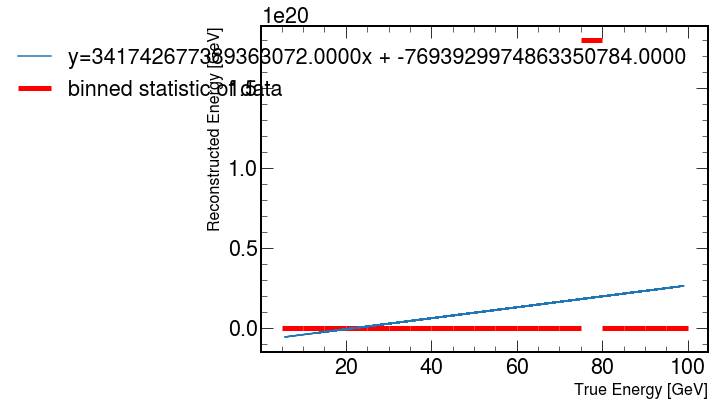

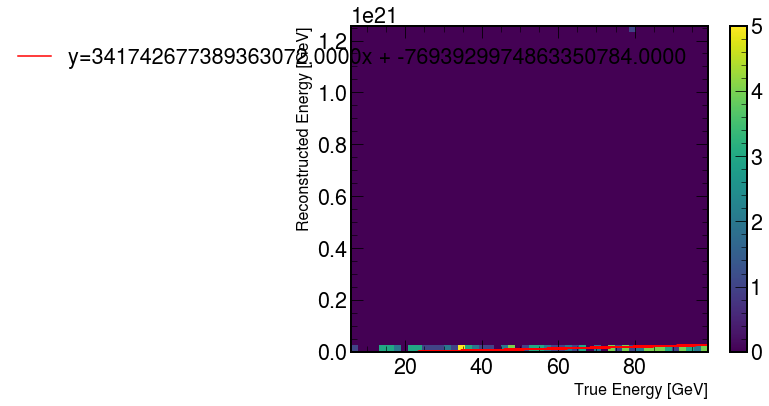

In [16]:
# calculate sfc
#binnings = np.concatenate((np.linspace(0,7,num=8), np.linspace(8, 14, num=4), np.linspace(16,20,num=2),np.array([25, 35, 50, 70, 100])))
binnings = np.linspace(0,100,21)
bin_avg,    bin_edges, binnumber = binned_statistic(particle_energy, event_energy, statistic='mean', bins=binnings, range=(0,100))
bincenters = np.array([0.5 * (binnings[i] + binnings[i+1]) for i in range(len(binnings)-1)])

plt.figure(figsize=(8,6))
plt.hlines(bin_avg, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
#plt.scatter(particle_energy,event_energy,c='red')
plt.xlabel('True Energy [GeV]',size=16)
plt.ylabel('Reconstructed Energy [GeV]',size=16)

particle_energy_array = np.array(particle_energy)
event_energy_array = np.array(event_energy)
m,b = np.polyfit(particle_energy_array,event_energy_array,1)
#m,b = np.polyfit(bincenters,bin_avg,1)
plt.plot(particle_energy_array, m*particle_energy_array + b,label='y={:.4f}x + {:.4f}'.format(m,b))
plt.legend()
print(m)
print(b)
sfc = m
plt.savefig('Sampling Fraction Correction Plot',facecolor='white',edgecolor='white',bbox_inches='tight')

plt.figure(figsize=(8,6))
plt.hist2d(particle_energy,event_energy,bins=50)
plt.colorbar()
plt.ylabel('Reconstructed Energy [GeV]',size=16)
plt.xlabel('True Energy [GeV]',size=16)

plt.plot(particle_energy_array, m*particle_energy_array + b,label='y={:.4f}x + {:.4f}'.format(m,b),c='red')
plt.legend()
plt.savefig('Photon: True vs Reco Energy',facecolor='white',edgecolor='white',bbox_inches='tight')

In [31]:
# energy resolution data
truth_energy = np.array(particle_energy)
reco_energy = np.array(event_energy)
cluster_energy_array = np.array(cluster_energies)

energy=[energy_10,energy_20,energy_30,energy_40,energy_50,energy_60,energy_70,energy_80,energy_90,energy_100]

def func(x, a,b,c): # resolution function
    return np.sqrt((a**2) + (b**2)/x + (c**2)/np.sqrt(x))

def func1(x, A, mu, sig): # gaussian function
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        
def fitdata(data): # fits data to gaussian function to get mean and std
    n, bin_edges = np.histogram(data, bins=50, density=True)
    mask = n!=0
    bincenters = np.asarray([(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)])
    plt.hist(data,
            bins = 50,
            range = [-50,50],
            density = True)
    plt.show()
    popt, pcov = curve_fit(func1, xdata = bincenters[mask], ydata = n[mask], sigma=np.sqrt(n[mask]),absolute_sigma=False,p0=[1,0,.5])
    return popt[1], popt[2]

sigmas = []
means = []
for energy_list in energy: # energy = list of lists, each list has reco-truth energy values for a given bin
    #print(energy_list)
    mean_fit, std_fit = fitdata(np.asarray(energy_list)) # call fitdata to get mean and sigma
    print(std_fit,mean_fit)
    sigmas.append(std_fit)
    means.append(mean_fit)

sigmas = np.array(sigmas)
means = np.array(means)

print(sigmas) # check that it worked :(

NameError: name 'energy_10' is not defined

[95.89768527 57.82059142 38.84367362 ... 82.08787246 31.75406422
 70.35558185]
[90.5348587  56.05830383 37.28092194 ... 86.01119232 30.44054222
 68.28795624]
Truth momentum range: 20,30 GeV
1020 1020
Error for parameter esimations:  [inf inf inf inf inf inf]
Standard deviation (fit) is 0.5620194459409088
Mean (fit) is 0.0759610703191439
Resolution (fit) is 7.398782607717775
[0.10105371 0.07158981 0.07596107 0.56201945 0.91920926 2.        ]


/Users/wmccorma/miniconda3/envs/Sebastian_Res/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


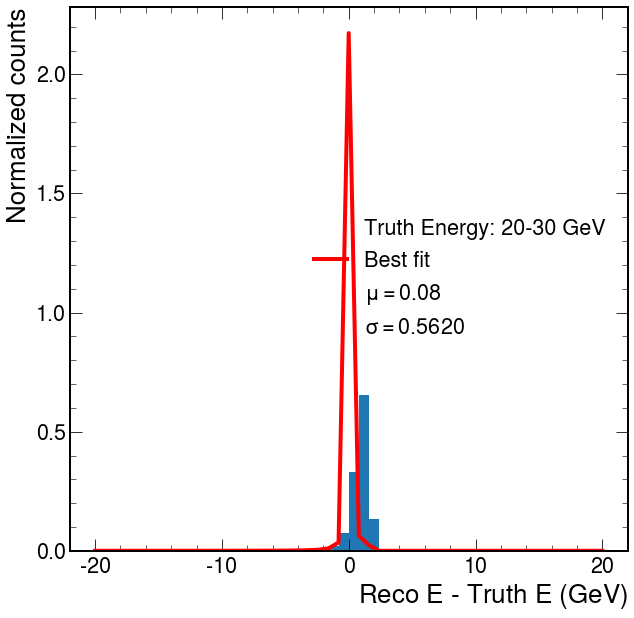

Truth momentum range: 30,40 GeV
991 991
Error for parameter esimations:  [inf inf inf inf inf inf]
Standard deviation (fit) is 0.5695983594874047
Mean (fit) is 0.06080323641267189
Resolution (fit) is 9.367895413026003
[0.08873346 0.02891241 0.06080324 0.56959836 0.8951791  2.        ]


/Users/wmccorma/miniconda3/envs/Sebastian_Res/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


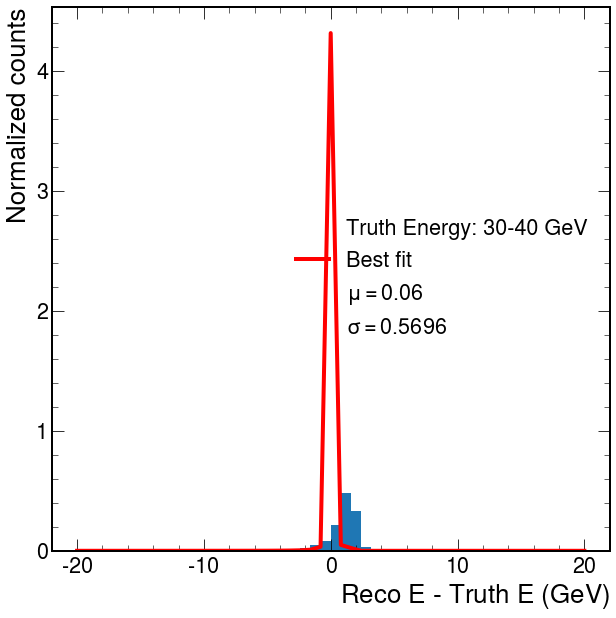

Truth momentum range: 40,50 GeV
1052 1052
Error for parameter esimations:  [inf inf inf inf inf inf]
Standard deviation (fit) is 0.6061360064033758
Mean (fit) is -0.012271099445954404
Resolution (fit) is -49.39541147661465
[-0.12939348  0.1501691  -0.0122711   0.60613601 -0.40822735  2.        ]


/Users/wmccorma/miniconda3/envs/Sebastian_Res/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


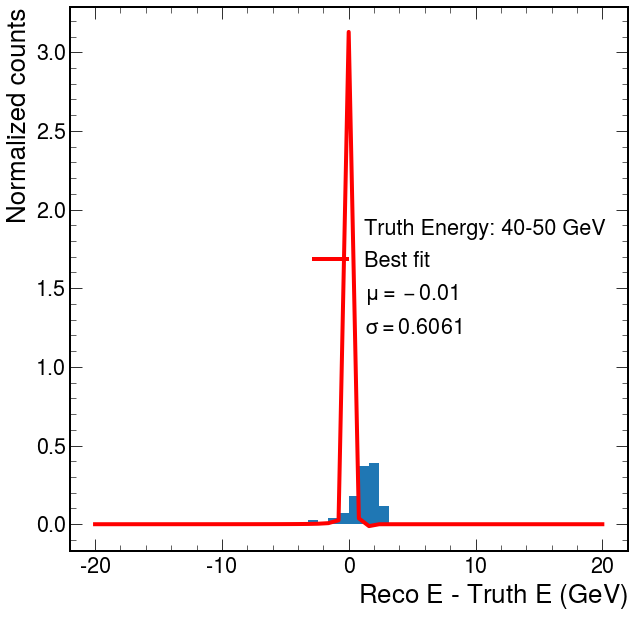

Truth momentum range: 50,60 GeV
940 940
Error for parameter esimations:  [inf inf inf inf inf inf]
Standard deviation (fit) is 0.5712386390079115
Mean (fit) is 0.05752261113789438
Resolution (fit) is 9.930679913652156
[0.07592768 0.01363147 0.05752261 0.57123864 0.86100432 2.        ]


/Users/wmccorma/miniconda3/envs/Sebastian_Res/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


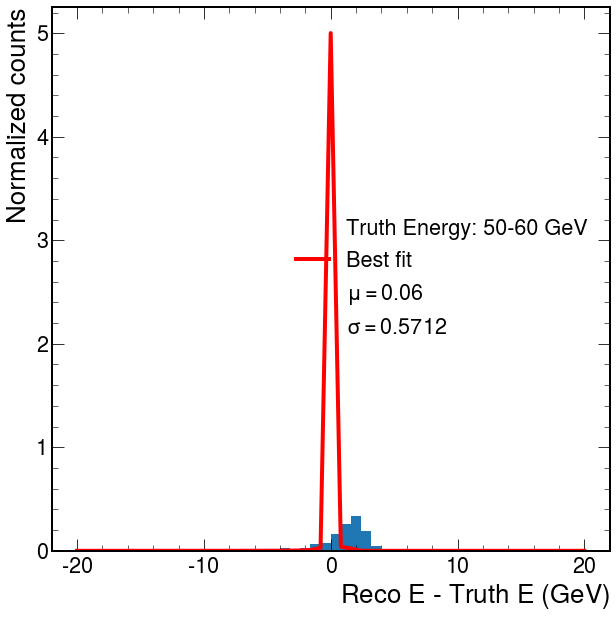

Truth momentum range: 60,70 GeV
977 977
Error for parameter esimations:  [inf inf inf inf inf inf]
Standard deviation (fit) is 0.5716071939545803
Mean (fit) is 0.05678554894097963
Resolution (fit) is 10.066067945362002
[0.06381992 0.0060423  0.05678555 0.57160719 0.832614   2.        ]


/Users/wmccorma/miniconda3/envs/Sebastian_Res/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


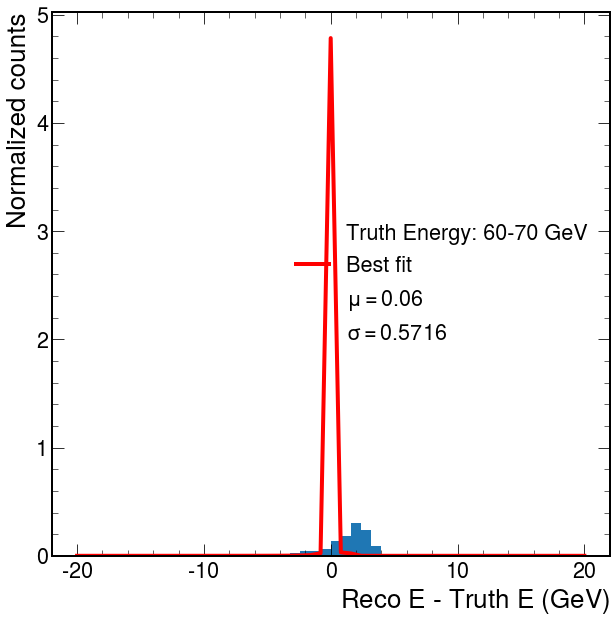

Truth momentum range: 70,80 GeV
1046 1046
Error for parameter esimations:  [1.60838960e+03 7.81982117e+03 4.49250690e+03 5.44229672e-01
 2.20731541e+04 1.89461239e+00]
Standard deviation (fit) is 0.5745023650232575
Mean (fit) is 0.05099525940648677
Resolution (fit) is 11.265799443118016
[ 0.06062775 -0.00951557  0.05099526  0.57450237  0.83204069  2.        ]


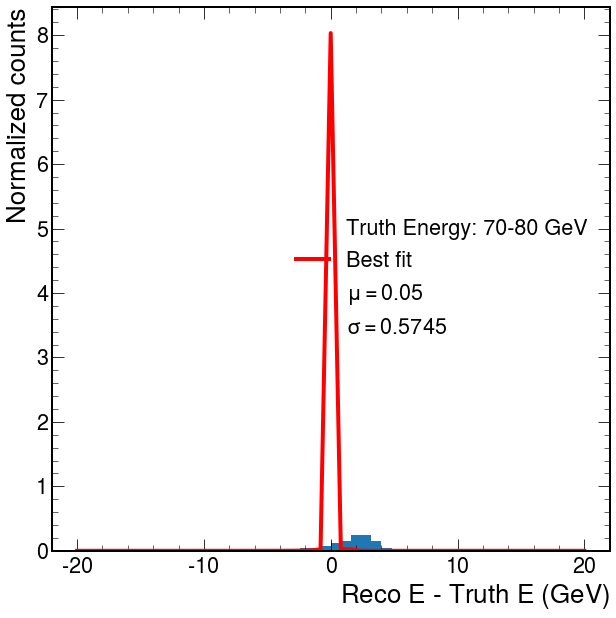

Truth momentum range: 80,90 GeV
1026 1026
Error for parameter esimations:  [inf inf inf inf inf inf]
Standard deviation (fit) is 0.5801573899920504
Mean (fit) is 0.03968508909665051
Resolution (fit) is 14.619027024964312
[ 0.05768309 -0.03660557  0.03968509  0.58015739  0.83608205  2.        ]


/Users/wmccorma/miniconda3/envs/Sebastian_Res/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


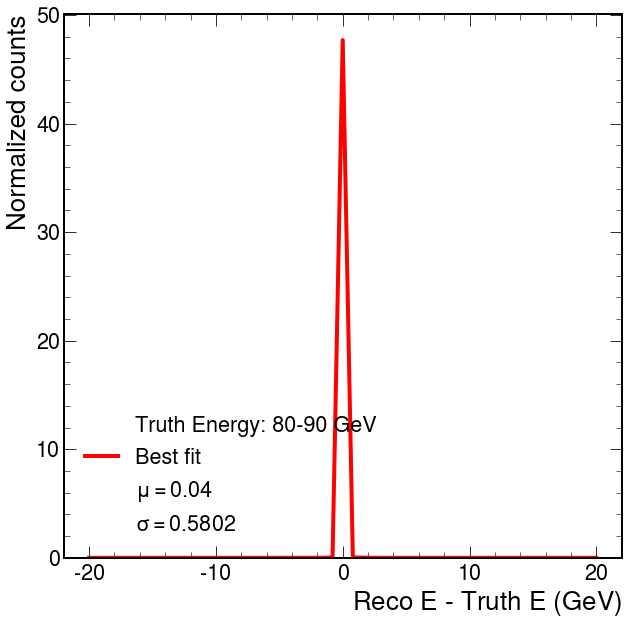

Truth momentum range: 90,100 GeV
999 999
Error for parameter esimations:  [inf inf inf inf inf inf]
Standard deviation (fit) is 0.5748661523754082
Mean (fit) is 0.05026742553942924
Resolution (fit) is 11.436156640337373
[ 0.05674494 -0.01091058  0.05026743  0.57486615  0.81636507  2.        ]


/Users/wmccorma/miniconda3/envs/Sebastian_Res/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


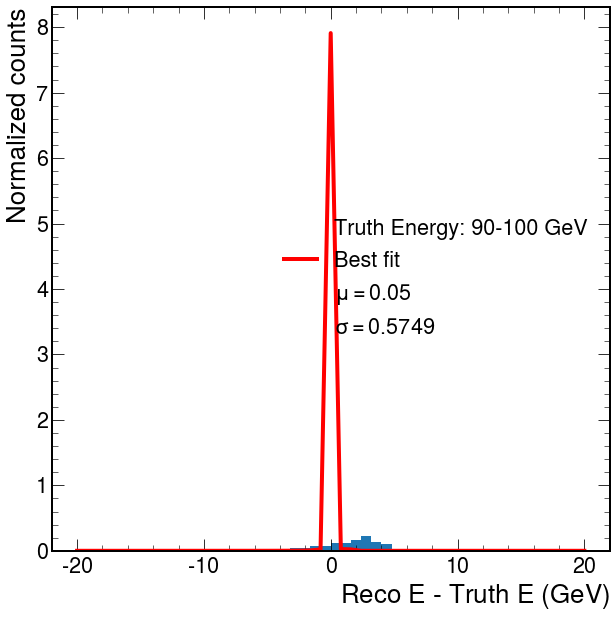

/Users/wmccorma/miniconda3/envs/Sebastian_Res/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


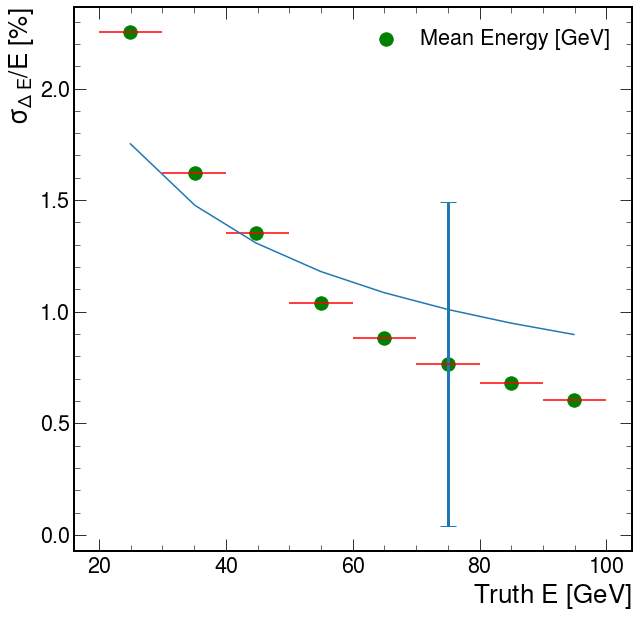

In [32]:
truth_energy = np.array(particle_energy)
reco_energy = np.array(event_energy) / sfc
cluster_energy_array = np.array(cluster_energies)

#print(event_energy)
print(reco_energy)
print(truth_energy)

def func(x, a,b,c): # resolution function
    return np.sqrt((a**2) + (b**2)/x + (c**2)/np.sqrt(x))

e_resolution = [] #To save the resolution (sigma) of the fit
e_average = []
e_ranges = []
e_err = []
    
#Specify the ranges to calculate the resolution in 
for i in [2,3,4,5,6,7,8,9]:
        
    hist_range = [-20,20]
        
    e_range = 10
    e_min = i*e_range #GeV
    e_max = (i+1)*e_range
    e_ranges.append([e_min,e_max]) #Save for resolution later
        
    print("Truth momentum range: {},{} GeV".format(e_min, e_max))
        
    local_selection = (truth_energy >= e_min) & (truth_energy < e_max)
    e_average.append(np.mean(truth_energy[local_selection]))
        
    e_residual = copy.deepcopy(reco_energy[local_selection] - truth_energy[local_selection])
    print(len(reco_energy[local_selection]),len(truth_energy[local_selection]))
    
    #hist_range=[min(e_residual)-2,max(e_residual)+2]
        
    if e_residual.size != 0:
        
        #Initial distribution and labelling
        plt.hist(e_residual,
                bins = 50,
                range = hist_range,
                density = True)
        plt.plot([],[], 'none', label="Truth Energy: {}-{} GeV".format(e_min, e_max))

        ## Gaussian fit
        ## Fit directly on the histogram
        def fit_function(x, A, mu, sig):
            return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
        
        def logistic(x, mu, sig):
            return (np.exp(-(x-mu)/sig)) / (sig*np.power((1+np.exp(-(x-mu)/sig)),2.))
        
        def cauchy(x,mu,sig):
            return (1) / (np.pi*sig*(1+np.power((x-mu)/sig,2)))
        
        def crystal_ball(x, A, B, mu, sig, N,a):
            y = np.piecewise(x,
                            [(x-mu)/sig > a, (x-mu)/sig <= a],
                            [lambda x: N*np.exp(-np.power(x-mu,2.) / (2*np.power(sig,2.))) ,
                             lambda x: N*A*np.power(B-((x-mu)/sig),-2)])
            return y

        bins = np.linspace(hist_range[0], hist_range[1], 51)
        binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
        data_entries, _ = np.histogram(e_residual, bins=bins,
                                           range = hist_range, density = True)

        mask = data_entries!=0
        #Fit the function to the histogram data.
        #popt, pcov = curve_fit(fit_function,
                                #xdata=binscenters[mask],
                                #ydata=data_entries[mask],
                                #sigma = np.sqrt(data_entries[mask]),
                                #absolute_sigma = False,
                                #p0=[1, 0, 0.5])

        popt, pcov = curve_fit(crystal_ball,
                                xdata=binscenters[mask],
                                ydata=data_entries[mask],
                                sigma = np.sqrt(data_entries[mask]),
                                absolute_sigma = False,
                                p0=[.15, 0.0, 0.0, 0.5,1.,2.],
                                maxfev=40000)

        #Error for parameter estimations
        err = np.sqrt(np.diag(pcov))
        print("Error for parameter esimations: ", err)
        #e_err.append(err[2])
        e_err.append(err[3])

        #std_fit = np.abs(popt[2])
        std_fit = np.abs(popt[3])
        #mean_fit = popt[1]
        mean_fit = popt[2]
        res_fit = std_fit/mean_fit
        #sigma_res = err[2]/mean_fit
        sigma_res = err[3]/mean_fit
        print("Standard deviation (fit) is", std_fit)
        print("Mean (fit) is", mean_fit)
        print("Resolution (fit) is {}".format(res_fit))
        e_resolution.append(std_fit)

        #Plot fitted gaussian
        #plt.plot(bins,
                #fit_function(bins, *popt),
                #"r-",
                #linewidth=4,
                #label='Best fit')
        
        print(popt)
        plt.plot(bins,
                crystal_ball(bins, *popt),
                "r-",
                linewidth=4,
                label='Best fit')

        #plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
        #plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%popt[2])
        
        plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[2])
        plt.plot([],[], 'none', label=r'$\sigma=%.4f$'%popt[3])

        #Label the axes
        plt.xlabel(r'Reco $E$ - Truth $E$ (GeV)')
        plt.ylabel('Normalized counts')

        plt.legend()
        fig = plt.gcf()
        plt.show()
        #fig.savefig('{}-{} GeV'.format(e_min,e_max),facecolor='white',edgecolor='white',bbox_inches='tight')

#MAIN PLOT
#Plot momentum average
#plt.scatter(p_average, p_resolution, s=180, c='#2ca02c', label = "Average p [GeV]", zorder = 10)
    
#Plot the resolution based on energy range.
plt.scatter(e_average,
            [x/y*100 for x, y in zip(e_resolution, e_average)],
            s = 180,
            label='Mean Energy [GeV]',
            c='green')

#Plot the error bars
plt.errorbar(e_average,
            [x/y*100 for x, y in zip(e_resolution, e_average)],
            yerr=[x/y*100 for x, y in zip(e_err, e_average)],
            fmt='none',
            elinewidth=3,
            capsize=8)

#Plot the bins
plt.hlines([x/y*100 for x, y in zip(e_resolution, e_average)],
            [e_range[0] for e_range in e_ranges],
            [e_range[1] for e_range in e_ranges],
            colors='red')

#Plot resolution function
popt, pcov = curve_fit(func,
                        xdata=e_average,
                        ydata=[x/y*100 for x, y in zip(e_resolution, e_average)],
                        )
plt.plot(e_average,func(e_average,*popt),
        #label='{:.3f}+$\frac{{:.3f}}{<E>} + \frac{{:.3f}}{\sqrt{<E>}}$'.format(*popt)
        )

#Label axes
plt.xlabel(r'Truth $E$ [GeV]')
plt.ylabel(r'$\sigma_{\Delta~E}/E$ [%]')
    
plt.legend()
fig = plt.gcf()
plt.show()

#fig.savefig('Photon 1910cm: Energy Resolution',facecolor='white',edgecolor='white',bbox_inches='tight')


[[Model]]
    Model(crystal_ball)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 50
    # variables        = 5
    chi-square         = 0.11575162
    reduced chi-square = 0.00257226
    Akaike info crit   = -293.416580
    Bayesian info crit = -283.856465
[[Variables]]
    A:    0.05906850 +/- 811.329597 (1373540.14%) (init = 0.15)
    B:   -0.01554662 +/- 8456.36679 (54393601.84%) (init = 0)
    mu:   0.04891402 +/- 4852.98721 (9921463.83%) (init = 0)
    sig:  0.57554101 +/- 900.353817 (156436.09%) (init = 0.5)
    N:    0.76855297 +/- 8151.79299 (1060667.68%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(B, mu)   = -1.000
    C(A, mu)   =  1.000
    C(A, B)    = -1.000
    C(A, N)    = -1.000
    C(mu, N)   = -1.000
    C(B, N)    =  1.000
    C(B, sig)  =  1.000
    C(mu, sig) = -1.000
    C(A, sig)  = -1.000
    C(sig, N)  =  1.000


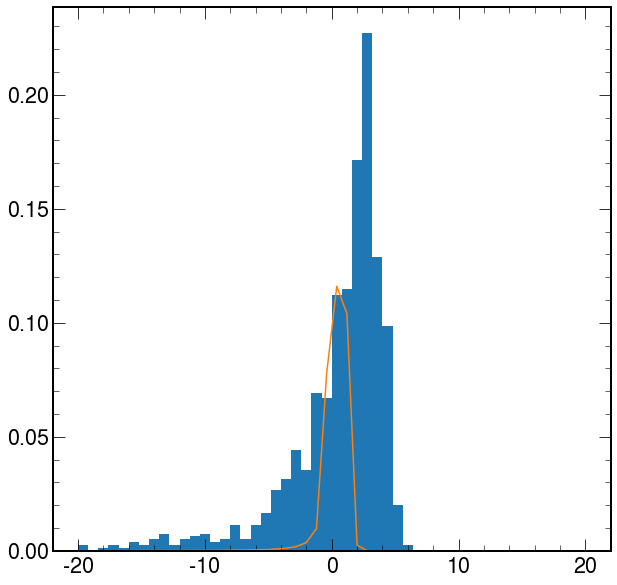

In [33]:
# try using lmfit instead
def crystal_ball(x, A, B, mu, sig, N):
            y = np.piecewise(x,
                            [(x-mu)/sig > 2, (x-mu)/sig <= 2],
                            [lambda x: N*np.exp(-np.power(x-mu,2.) / (2*np.power(sig,2.))) ,
                             lambda x: N*A*np.power(B-((x-mu)/sig),-2)])
            return y
cbmodel = Model(crystal_ball)
result = cbmodel.fit(data_entries,
                    x=binscenters,
                    A = .15,
                    B = 0.0,
                    mu= 0.0,
                    sig = 0.5,
                    N = 1)

print(result.fit_report())
plt.figure()
plt.hist(e_residual,
        bins = 50,
        range = hist_range,
        density = True)
plt.plot(binscenters, result.best_fit)

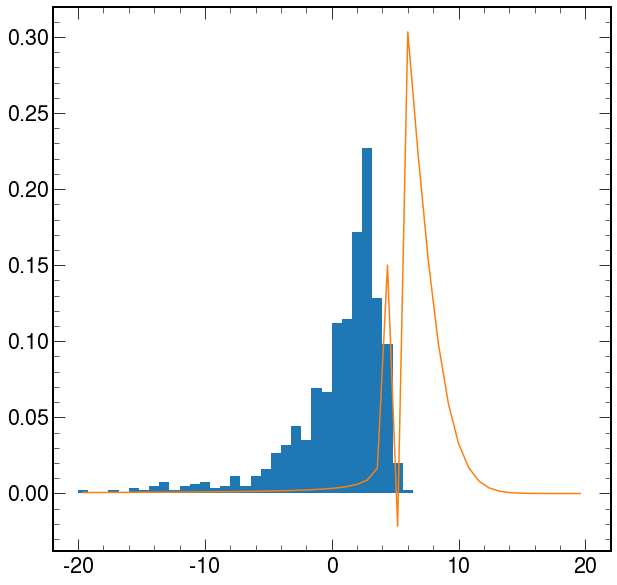

In [34]:
# test if initial values are a good guess
def crystal_ball(x, A, B, mu, sig, N):
        y = np.piecewise(x,
                        [(x-mu)/sig > 1, (x-mu)/sig <= 1],
                        [lambda x: N*np.exp(-np.power(x-mu,2.) / (2*np.power(sig,2.))) ,
                        lambda x: N*A*np.power(B-((x-mu)/sig),-1)])
        return y

plt.figure()
plt.hist(e_residual,
        bins = 50,
        range = hist_range,
        density = True)
plt.plot(binscenters, crystal_ball(binscenters,.01,.5,3,3,.5))

999


(array([0.0025227 , 0.        , 0.00126135, 0.0025227 , 0.00126135,
        0.00378406, 0.0025227 , 0.00504541, 0.00756811, 0.0025227 ,
        0.00504541, 0.00630676, 0.00756811, 0.00378406, 0.00504541,
        0.01135217, 0.00504541, 0.01135217, 0.01639758, 0.0264884 ,
        0.0315338 , 0.04414733, 0.03531786, 0.06937437, 0.06685166,
        0.11226034, 0.11478305, 0.1715439 , 0.22704339, 0.12865792,
        0.09838547, 0.02018163, 0.0025227 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([-20. , -19.2, -18.4, -17.6, -16.8, -16. , -15.2, -14.4, -13.6,
        -12.8, -12. , -11.2, -10.4,  -9.6,  -8.8,  -8. ,  -7.2,  -6.4,
         -5.6,  -4.8,  -4. ,  -3.2,  -2.4,  -1.6,  -0.8,   0. ,   0.8,
          1.6,   2.4,   3.2,   4. ,   4.8,   5.6,   6.4,   7.2,   8. ,
          8.8,   9.6,  10.4,  11.2

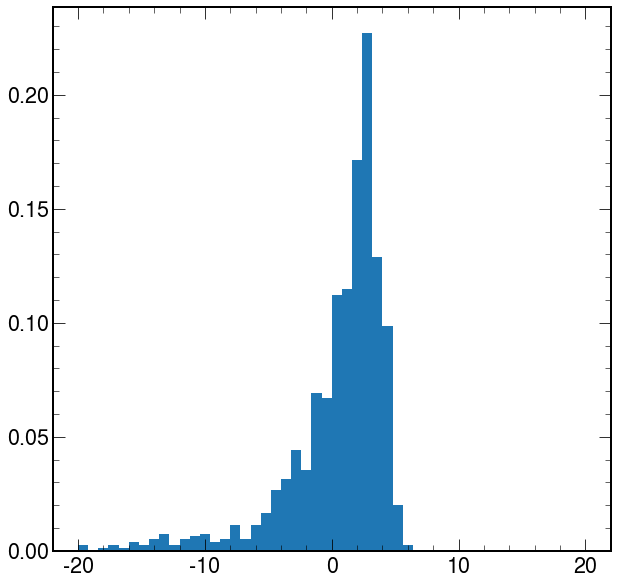

In [35]:
plt.figure()
print(np.size(e_residual))
plt.hist(e_residual,
        bins = 50,
        range = hist_range,
        density = True)

In [36]:
test_hist = ROOT.TH1F('res1','',50,-20,20)
for eres in e_residual:
    test_hist.Fill(eres)

In [37]:
#crfun = ROOT.TF1('fitFunction', ROOT.Math.crystalball_function(1,2,1,1,0), -20, 20)
f1 = ROOT.TF1('fitFunction', "crystalball", -20, 20)
#f1 = ROOT.TF1('fitFunction', "ROOT::Math::crystalball_function(x, 2, 1, 1, 1)", -20, 20)
f1.SetParameters(100, 1, 1, 1, 1);
#crfun = ROOT.Math.crystalball_function(x[0], par[0], par[1], par[2], par[3])

In [38]:
test_hist.Fit(f1, 'S')

 FCN=38.7549 FROM MIGRAD    STATUS=CONVERGED     307 CALLS         308 TOTAL
                     EDM=8.00531e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.5 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.64694e+02   7.93793e+00   6.56469e-03   1.50950e-05
   2  Mean         2.69179e+00   1.01999e-01  -4.31987e-05   1.57529e-03
   3  Sigma        1.17373e+00   6.36435e-02   1.81008e-07   1.55145e-03
   4  Alpha        4.81102e-01   6.30670e-02   9.59095e-06  -1.84905e-03
   5  N            5.53569e+00   1.96493e+00   5.52367e-04  -3.53332e-05


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


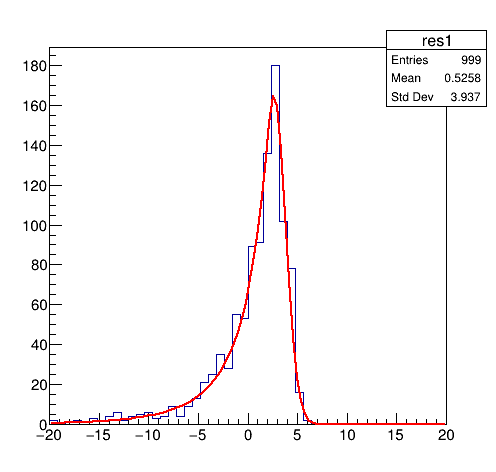

In [39]:
can1 = ROOT.TCanvas('a','a', 500, 500)
test_hist.Draw()
f1.Draw('same')
can1.Draw()